## Chronos

In [ ]:
pip install chronos-forecasting

In [9]:
import pandas as pd
from chronos import BaseChronosPipeline

pipeline = BaseChronosPipeline.from_pretrained("amazon/chronos-2", device_map="cuda")

In [10]:
!pip -q install boto3 botocore


CUDA: True | device=cuda | macro_lag_bdays=20
Daily panel: 2000-01-31 → 2025-11-10 | rows=9416
S_b: 2000-01-31 → 2025-11-10 | n=6726
DF_d: 2000-01-31 → 2025-11-10 | rows=9416

Dropped months and reasons:
  2000-01: no_cut_in_prev_month
  2000-02: hist<40
  2000-03: hist<40

Dropped months and reasons:
  2000-01: no_cut_in_prev_month
  2000-02: hist<40
  2000-03: hist<40

Dropped months and reasons:
  2000-01: no_cut_in_prev_month
  2000-02: hist<40
  2000-03: hist<40

=== MONTHLY (Chronos-2) ===
                         Model  Obs     RMSE      MAE   DirAcc  DM_vs_RW  p_vs_RW  DM_n
Chronos-2 (pastcov: macro+fin)  308 0.143999 0.100925 0.664495 -2.718975 0.006548   307
        Chronos-2 (price-only)  308 0.144389 0.097390 0.700326 -1.893609 0.058277   307
    Chronos-2 (pastcov: macro)  308 0.147977 0.102464 0.664495 -2.165869 0.030321   307


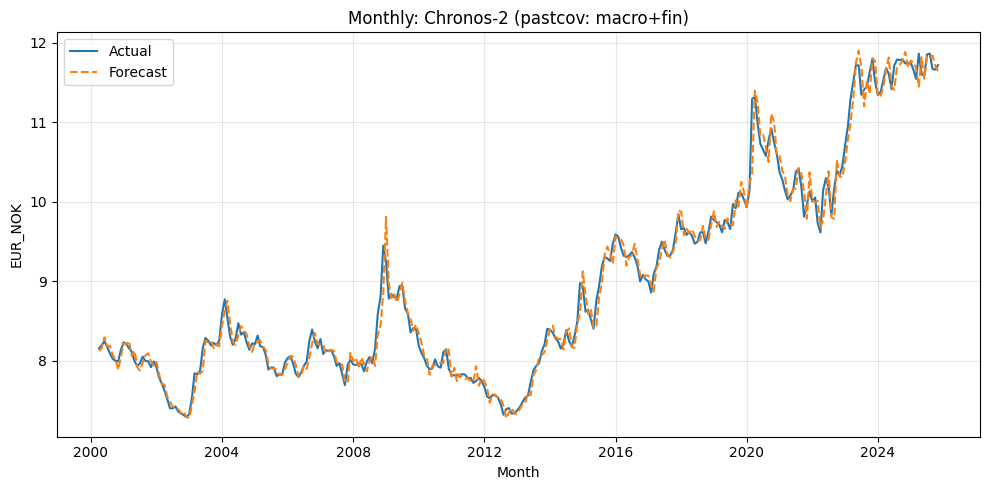

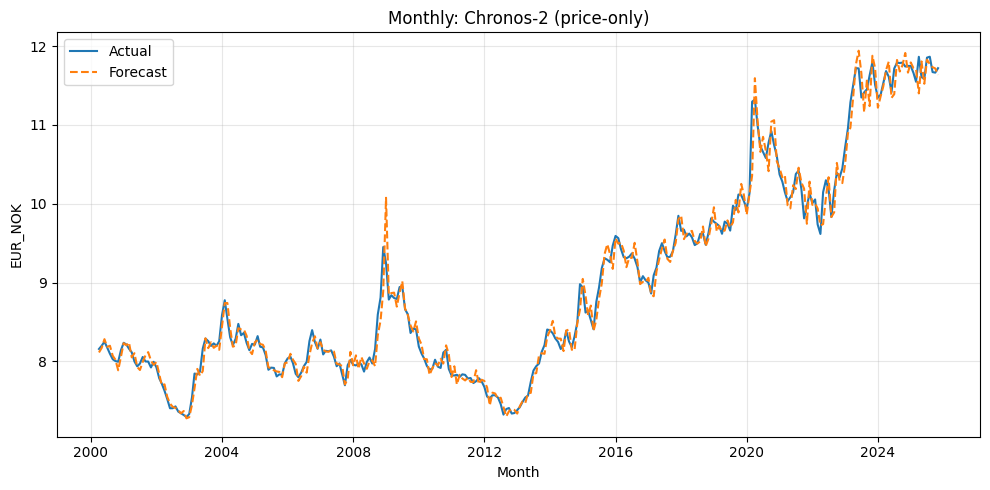


=== REGIME TABLES (MONTHLY) ===

--- Full sample ---
                         Model  Obs     RMSE      MAE   DirAcc  DM_vs_RW  p_vs_RW  DM_n
Chronos-2 (pastcov: macro+fin)  308 0.143999 0.100925 0.664495 -2.718975 0.006548   307
        Chronos-2 (price-only)  308 0.144389 0.097390 0.700326 -1.893609 0.058277   307
    Chronos-2 (pastcov: macro)  308 0.147977 0.102464 0.664495 -2.165869 0.030321   307

--- Pre-GFC ---
                         Model  Obs     RMSE      MAE   DirAcc  DM_vs_RW  p_vs_RW  DM_n
        Chronos-2 (price-only)   92 0.078984 0.059693 0.802198 -4.425876 0.000010    91
    Chronos-2 (pastcov: macro)   92 0.087751 0.067846 0.769231 -4.294887 0.000017    91
Chronos-2 (pastcov: macro+fin)   92 0.088168 0.067324 0.802198 -4.163623 0.000031    91

--- GFC+ ---
                         Model  Obs     RMSE      MAE   DirAcc  DM_vs_RW  p_vs_RW  DM_n
Chronos-2 (pastcov: macro+fin)  143 0.133464 0.096621 0.626761 -1.154314 0.248371   142
        Chronos-2 (price-only)  143

In [6]:
# ============================================================
# Chronos-2 (Monthly) — A++ package (regimes + pairwise DM + NULL-centered block bootstrap)
# - Data: variables_daily.csv (daily wide)
# - Target: EUR_NOK
# - Cut: last business day of previous month
# - Forecast: daily next-month -> aggregate to monthly mean over business days
# - Models (Chronos-2 only):
#     1) price-only
#     2) pastcov: macro (with 20 B-day publication lag applied to macro covariates)
#     3) pastcov: macro+fin (macro lag + fin as-of t-1)
# - Table Obs = #forecasts (target ~308); DM_n = sample used in DM vs RW (usually Obs-1)
# ============================================================

# !pip -q install chronos-forecasting pandas numpy scikit-learn matplotlib requests certifi torch joblib

from __future__ import annotations
import io, math, time, warnings
from dataclasses import dataclass
from typing import Optional, Dict, Tuple, List

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests, certifi

import torch
from sklearn.metrics import mean_absolute_error
from chronos import BaseChronosPipeline

warnings.filterwarnings("ignore")


# -----------------------------
# CONFIG
# -----------------------------
@dataclass
class CFG:
    url_daily: str = (
        "https://raw.githubusercontent.com/bredeespelid/"
        "Data_MasterOppgave/refs/heads/main/Variables/All_Variables/variables_daily.csv"
    )
    target: str = "EUR_NOK"

    fin_cols: Tuple[str, ...] = ("Brent", "VIX", "StoxEurope", "SP500", "OSEBX", "OBX_Energy")
    macro_cols: Tuple[str, ...] = ("Q", "d_pi", "dI_t")

    macro_lag_bdays: int = 20          # publication lag in business days
    min_hist_days: int = 40
    max_horizon_days: int = 64         # month-length guard

    # Chronos-2: correct identifier is on S3
    chronos_model: str = "s3://autogluon/chronos-2"
    chronos_max_context: int = 2048
    chronos_fp16_on_cuda: bool = True

    # Bootstrap (A++): null-centered MBB
    bootstrap_B: int = 800
    bootstrap_block: Optional[int] = None  # None -> auto ~ n^(1/3)

    # Download
    retries: int = 3
    timeout: int = 60

C = CFG()

USE_CUDA = bool(torch.cuda.is_available())
DEVICE = "cuda" if USE_CUDA else "cpu"
print(f"CUDA: {USE_CUDA} | device={DEVICE} | macro_lag_bdays={C.macro_lag_bdays}")


# -----------------------------
# DOWNLOAD + LOAD
# -----------------------------
def download_csv_text(url: str, retries: int, timeout: int) -> str:
    last_err = None
    for k in range(1, retries + 1):
        try:
            r = requests.get(url, timeout=timeout, verify=certifi.where())
            r.raise_for_status()
            return r.text
        except Exception as e:
            last_err = e
            if k < retries:
                time.sleep(1.2 * k)
    raise RuntimeError(f"Download failed: {last_err}")


def load_daily_panel(url: str) -> pd.DataFrame:
    text = download_csv_text(url, retries=C.retries, timeout=C.timeout)
    df = pd.read_csv(io.StringIO(text))
    if "Date" not in df.columns:
        raise KeyError("Daily panel must contain column 'Date'.")

    df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
    df = df.dropna(subset=["Date"]).sort_values("Date").set_index("Date")

    for col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

    if C.target not in df.columns:
        raise KeyError(f"Target {C.target} not found in daily panel.")

    return df


def to_business_and_daily_wide(df: pd.DataFrame) -> Tuple[pd.Series, pd.DataFrame]:
    keep = [C.target] + [c for c in (list(C.fin_cols) + list(C.macro_cols)) if c in df.columns]
    df0 = df[keep].copy()

    # Business-day truth base
    S_b = df0[C.target].asfreq("B").ffill().astype(float)
    S_b.name = C.target

    # Calendar-day (inputs)
    full_idx = pd.date_range(df0.index.min(), df0.index.max(), freq="D")
    DF_d = df0.reindex(full_idx).ffill()
    DF_d.index.name = "DATE"

    return S_b, DF_d


def last_trading_day(S_b: pd.Series, start: pd.Timestamp, end: pd.Timestamp) -> Optional[pd.Timestamp]:
    sl = S_b.loc[start:end]
    return sl.index[-1] if not sl.empty else None


# -----------------------------
# PERIOD + TRUTH
# -----------------------------
def period_range_from_series(idx: pd.DatetimeIndex, freq: str) -> pd.PeriodIndex:
    first = pd.Period(idx.min(), freq=freq)
    last  = pd.Period(idx.max(), freq=freq)
    return pd.period_range(first, last, freq=freq)


def truth_mean_bdays(S_b: pd.Series, p: pd.Period) -> Optional[float]:
    idx = S_b.index[(S_b.index >= p.start_time) & (S_b.index <= p.end_time)]
    if idx.size == 0:
        return None
    return float(S_b.loc[idx].mean())


# -----------------------------
# METRICS + DM (two-sided)
# -----------------------------
def _normal_cdf(z: float) -> float:
    return 0.5 * (1.0 + math.erf(z / math.sqrt(2.0)))


def eval_metrics(df_eval: pd.DataFrame) -> Dict[str, float]:
    core = df_eval.dropna(subset=["y_true", "y_pred"]).copy()
    n = int(len(core))
    if n == 0:
        return dict(obs=0, rmse=np.nan, mae=np.nan, diracc=np.nan)

    err = core["y_true"] - core["y_pred"]
    rmse = float(np.sqrt(np.mean(err**2)))
    mae  = float(mean_absolute_error(core["y_true"], core["y_pred"]))

    core["y_prev"] = core["y_true"].shift(1)
    mask = core["y_prev"].notna()
    if mask.any():
        dir_true = np.sign(core.loc[mask, "y_true"] - core.loc[mask, "y_prev"])
        dir_pred = np.sign(core.loc[mask, "y_pred"] - core.loc[mask, "y_prev"])
        diracc = float((dir_true.values == dir_pred.values).mean())
    else:
        diracc = np.nan

    return dict(obs=n, rmse=rmse, mae=mae, diracc=diracc)


def _dm_from_d(d: np.ndarray) -> float:
    d = np.asarray(d, dtype=float)
    n = d.size
    if n < 10:
        return float("nan")
    sd = float(d.std(ddof=1))
    if not np.isfinite(sd) or sd <= 0:
        return float("nan")
    return float(d.mean() / (sd / math.sqrt(n)))


def dm_vs_rw(df_eval: pd.DataFrame) -> Tuple[float, float, int]:
    core = df_eval.dropna(subset=["y_true", "y_pred"]).copy()
    core["rw_pred"] = core["y_true"].shift(1)
    core = core.dropna(subset=["rw_pred"])
    if len(core) < 10:
        return float("nan"), float("nan"), int(len(core))

    e_m = core["y_true"].to_numpy() - core["y_pred"].to_numpy()
    e_r = core["y_true"].to_numpy() - core["rw_pred"].to_numpy()
    d = (e_m**2) - (e_r**2)  # MSE difference

    dm = _dm_from_d(d)
    p  = float(2.0 * (1.0 - _normal_cdf(abs(dm)))) if np.isfinite(dm) else float("nan")
    return float(dm), float(p), int(len(d))


def dm_pairwise(df_a: pd.DataFrame, df_b: pd.DataFrame) -> Tuple[float, float, int]:
    df = pd.concat({"y": df_a["y_true"], "a": df_a["y_pred"], "b": df_b["y_pred"]}, axis=1).dropna()
    if len(df) < 10:
        return float("nan"), float("nan"), int(len(df))
    e_a = df["y"].to_numpy() - df["a"].to_numpy()
    e_b = df["y"].to_numpy() - df["b"].to_numpy()
    d = (e_a**2) - (e_b**2)
    dm = _dm_from_d(d)
    p  = float(2.0 * (1.0 - _normal_cdf(abs(dm)))) if np.isfinite(dm) else float("nan")
    return float(dm), float(p), int(len(d))


# -----------------------------
# NULL-centered block bootstrap DM vs RW (one-sided, default: better than RW => DM < 0)
# -----------------------------
def block_bootstrap_dm_vs_rw_null_centered(
    df_eval: pd.DataFrame,
    B: int,
    block: Optional[int],
    seed: int = 42,
    one_sided: bool = True,
) -> Dict[str, float]:
    core = df_eval.dropna(subset=["y_true", "y_pred"]).copy()
    core["rw_pred"] = core["y_true"].shift(1)
    core = core.dropna(subset=["rw_pred"])

    n = int(len(core))
    if n < 30:
        return {"n": n, "dm_hat": np.nan, "p_boot": np.nan, "block": np.nan}

    e_m = core["y_true"].to_numpy() - core["y_pred"].to_numpy()
    e_r = core["y_true"].to_numpy() - core["rw_pred"].to_numpy()
    d = (e_m**2) - (e_r**2)

    dm_hat = _dm_from_d(d)
    if not np.isfinite(dm_hat):
        return {"n": n, "dm_hat": float("nan"), "p_boot": float("nan"), "block": float("nan")}

    # null-centering
    d0 = d - d.mean()

    # block length
    if block is None:
        b = int(round(n ** (1/3)))
        b = max(5, min(b, max(5, n // 2)))
    else:
        b = int(block)
        b = max(2, min(b, max(2, n // 2)))

    rng = np.random.default_rng(seed)
    starts = np.arange(0, n - b + 1)
    if starts.size == 0:
        return {"n": n, "dm_hat": float(dm_hat), "p_boot": np.nan, "block": float(b)}

    dm_boot = np.empty(B, dtype=float)
    dm_boot[:] = np.nan

    for i in range(B):
        idx = []
        while len(idx) < n:
            s = int(rng.choice(starts))
            idx.extend(range(s, s + b))
        idx = idx[:n]
        d_s = d0[np.array(idx, dtype=int)]
        dm_boot[i] = _dm_from_d(d_s)

    dm_boot = dm_boot[np.isfinite(dm_boot)]
    if dm_boot.size < 50:
        return {"n": n, "dm_hat": float(dm_hat), "p_boot": np.nan, "block": float(b)}

    if one_sided:
        if dm_hat < 0:
            p_boot = float(np.mean(dm_boot <= dm_hat))
        else:
            p_boot = float(np.mean(dm_boot >= dm_hat))
    else:
        p_boot = float(np.mean(np.abs(dm_boot) >= abs(dm_hat)))

    return {"n": n, "dm_hat": float(dm_hat), "p_boot": float(p_boot), "block": float(b)}


# -----------------------------
# REGIMES (same as your XGB)
# -----------------------------
@dataclass(frozen=True)
class Regime:
    name: str
    start: str
    end: str

REGIMES = [
    Regime("Full sample", "1900-01-01", "2100-01-01"),
    Regime("Pre-GFC", "2000-01-01", "2007-12-31"),
    Regime("GFC+", "2008-01-01", "2019-12-31"),
    Regime("COVID+", "2020-01-01", "2021-12-31"),
    Regime("Energy+FX shock", "2022-01-01", "2100-01-01"),
]

def filter_eval_by_regime(df_eval: pd.DataFrame, reg: Regime) -> pd.DataFrame:
    ts = df_eval.index.to_timestamp(how="end")
    mask = (ts >= pd.Timestamp(reg.start)) & (ts <= pd.Timestamp(reg.end))
    return df_eval.loc[mask]


# -----------------------------
# CHRONOS PIPELINE
# -----------------------------
def build_chronos_pipeline() -> BaseChronosPipeline:
    if USE_CUDA and C.chronos_fp16_on_cuda:
        return BaseChronosPipeline.from_pretrained(C.chronos_model, device_map="cuda", dtype=torch.float16)
    if USE_CUDA:
        return BaseChronosPipeline.from_pretrained(C.chronos_model, device_map="cuda", dtype=torch.float32)
    return BaseChronosPipeline.from_pretrained(C.chronos_model, device_map="cpu", dtype=torch.float32)


def _last_known_macro_at_cut(DF_hist: pd.DataFrame, col: str, cut: pd.Timestamp) -> float:
    # macro known only up to lag_cut (publication lag)
    lag_cut = cut - pd.tseries.offsets.BDay(C.macro_lag_bdays)
    s = DF_hist[col].loc[:lag_cut].dropna()
    return float(s.iloc[-1]) if not s.empty else np.nan


def _last_known_fin_at_cut(DF_hist: pd.DataFrame, col: str, cut: pd.Timestamp) -> float:
    # fin known as-of cut (t-1 for first forecast day)
    s = DF_hist[col].loc[:cut].dropna()
    return float(s.iloc[-1]) if not s.empty else np.nan


def make_context_and_future_df(
    DF_d: pd.DataFrame,
    cut: pd.Timestamp,
    H: int,
    cov_cols: List[str],
) -> Tuple[pd.DataFrame, Optional[pd.DataFrame]]:
    """
    Builds:
      - context_df: id,timestamp,target + past covariates (leakage-safe)
      - future_df:  id,timestamp + future covariates (frozen past-only)
    We enforce:
      - macro: publication lag (only known up to lag_cut), then shift 1 day (as-of t-1)
      - fin: shift 1 day (as-of t-1)
      - future covariates: constant at last known values at cut (macro uses lag_cut)
    """
    hist = DF_d.loc[:cut].copy()
    hist = hist.dropna(subset=[C.target])
    if len(hist) == 0:
        raise ValueError("Empty history at cut.")

    # base context
    ctx = pd.DataFrame({
        "id": C.target,
        "timestamp": hist.index,
        "target": hist[C.target].astype(float).values,
    })

    # add leakage-safe covariates
    for c in cov_cols:
        if c not in hist.columns:
            continue
        if c in C.macro_cols:
            # publication lag: after lag_cut, macro is not updated (stays at last known)
            lag_cut = cut - pd.tseries.offsets.BDay(C.macro_lag_bdays)
            safe = DF_d[c].loc[:lag_cut].reindex(hist.index).ffill()
            ctx[c] = safe.shift(1).astype(float).values  # as-of t-1
        else:
            # fin as-of t-1
            ctx[c] = hist[c].shift(1).astype(float).values

    # drop initial NaNs induced by shift(1)
    ctx = ctx.dropna()

    # future covariates (only needed if cov_cols non-empty)
    if len(cov_cols) == 0:
        return ctx, None

    f_start = cut + pd.Timedelta(days=1)
    f_idx = pd.date_range(f_start, periods=H, freq="D")
    fut = pd.DataFrame({"id": C.target, "timestamp": f_idx})

    for c in cov_cols:
        if c in C.macro_cols:
            const = _last_known_macro_at_cut(DF_d, c, cut)
        else:
            const = _last_known_fin_at_cut(DF_d, c, cut)
        fut[c] = const

    return ctx, fut


def chronos_predict_daily(
    pipe: BaseChronosPipeline,
    context_df: pd.DataFrame,
    H: int,
    future_df: Optional[pd.DataFrame] = None,
) -> pd.Series:
    with torch.inference_mode():
        pred = pipe.predict_df(
            context_df,
            future_df=future_df,
            prediction_length=H,
            quantile_levels=[0.5],
            id_column="id",
            timestamp_column="timestamp",
            target="target",
        )

    pred = pred.sort_values("timestamp")
    # robust extraction
    if "0.5" in pred.columns:
        yhat = pred["0.5"].to_numpy(dtype=float)[:H]
    elif "predictions" in pred.columns:
        yhat = pred["predictions"].to_numpy(dtype=float)[:H]
    elif "y_pred" in pred.columns:
        yhat = pred["y_pred"].to_numpy(dtype=float)[:H]
    else:
        raise RuntimeError(f"Unsupported Chronos output columns: {list(pred.columns)}")

    idx = pd.to_datetime(pred["timestamp"].to_numpy()[:H])
    return pd.Series(yhat, index=idx, dtype=float)


# -----------------------------
# WALK-FORWARD (MONTHLY)
# -----------------------------
def walk_forward_chronos_monthly(
    S_b: pd.Series,
    DF_d: pd.DataFrame,
    pipe: BaseChronosPipeline,
    cov_cols: List[str],
) -> pd.DataFrame:
    months = period_range_from_series(S_b.index, freq="M")
    rows, dropped = [], {}

    for m in months:
        prev_m = m - 1
        cut = last_trading_day(S_b, prev_m.start_time, prev_m.end_time)
        if cut is None:
            dropped[str(m)] = "no_cut_in_prev_month"
            continue

        # truth
        y_true = truth_mean_bdays(S_b, m)
        if y_true is None:
            dropped[str(m)] = "no_truth"
            continue

        # horizon is full calendar month length (same as XGB monthly)
        H = int((m.end_time.date() - m.start_time.date()).days + 1)
        if H <= 0 or H > C.max_horizon_days:
            dropped[str(m)] = f"horizon_invalid(H={H})"
            continue

        # history guard
        hist = DF_d.loc[:cut].dropna(subset=[C.target])
        if len(hist) < C.min_hist_days:
            dropped[str(m)] = f"hist<{C.min_hist_days}"
            continue

        # build context + future (frozen past-only covariates)
        ctx, fut = make_context_and_future_df(DF_d, cut=cut, H=H, cov_cols=cov_cols)

        # context truncation for speed (Chronos can handle longer, but we cap)
        if len(ctx) > C.chronos_max_context:
            ctx = ctx.iloc[-C.chronos_max_context:].copy()

        # daily prediction
        pred_daily = chronos_predict_daily(pipe, ctx, H=H, future_df=fut)

        # aggregate to business days in month
        idx_b = S_b.index[(S_b.index >= m.start_time) & (S_b.index <= m.end_time)]
        pred_b = pred_daily.reindex(idx_b, method=None)
        if pred_b.isna().all():
            dropped[str(m)] = "no_overlap_pred_B_days"
            continue

        y_pred = float(pred_b.dropna().mean())
        rows.append({"period": m, "cut": cut, "y_true": y_true, "y_pred": y_pred})

    df = pd.DataFrame(rows).set_index("period").sort_index()
    if dropped:
        print("\nDropped months and reasons:")
        for k, v in dropped.items():
            print(f"  {k}: {v}")
    return df


# -----------------------------
# TABLE + PLOTS
# -----------------------------
def summary_table(models: Dict[str, pd.DataFrame]) -> pd.DataFrame:
    rows = []
    for name, df_eval in models.items():
        st = eval_metrics(df_eval)
        dm, p, n_dm = dm_vs_rw(df_eval)
        rows.append({
            "Model": name,
            "Obs": st["obs"],
            "RMSE": st["rmse"],
            "MAE": st["mae"],
            "DirAcc": st["diracc"],
            "DM_vs_RW": dm,
            "p_vs_RW": p,
            "DM_n": n_dm,
        })
    return pd.DataFrame(rows).sort_values("RMSE")


def plot_actual_vs_pred(df_eval: pd.DataFrame, title: str):
    core = df_eval.dropna(subset=["y_true", "y_pred"]).copy()
    if core.empty:
        return
    x = core.index.to_timestamp()
    plt.figure(figsize=(10, 5))
    plt.plot(x, core["y_true"], label="Actual")
    plt.plot(x, core["y_pred"], "--", label="Forecast")
    plt.title(title)
    plt.xlabel("Month")
    plt.ylabel(C.target)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()


# -----------------------------
# RUN
# -----------------------------
df_daily = load_daily_panel(C.url_daily)
S_b, DF_d = to_business_and_daily_wide(df_daily)

print(f"Daily panel: {df_daily.index.min().date()} → {df_daily.index.max().date()} | rows={len(df_daily)}")
print(f"S_b: {S_b.index.min().date()} → {S_b.index.max().date()} | n={len(S_b)}")
print(f"DF_d: {DF_d.index.min().date()} → {DF_d.index.max().date()} | rows={len(DF_d)}")

pipe = build_chronos_pipeline()

macro_cov = [c for c in C.macro_cols if c in DF_d.columns]
fin_cov   = [c for c in C.fin_cols if c in DF_d.columns]

models = {
    "Chronos-2 (price-only)": walk_forward_chronos_monthly(S_b, DF_d, pipe, cov_cols=[]),
    "Chronos-2 (pastcov: macro)": walk_forward_chronos_monthly(S_b, DF_d, pipe, cov_cols=macro_cov),
    "Chronos-2 (pastcov: macro+fin)": walk_forward_chronos_monthly(S_b, DF_d, pipe, cov_cols=(macro_cov + fin_cov)),
}

tbl = summary_table(models)
print("\n=== MONTHLY (Chronos-2) ===")
print(tbl.to_string(index=False))

# Plot top-2
top2 = tbl["Model"].head(2).tolist()
for m in top2:
    plot_actual_vs_pred(models[m], f"Monthly: {m}")

# Regime tables
print("\n=== REGIME TABLES (MONTHLY) ===")
for reg in REGIMES:
    sub = {k: filter_eval_by_regime(v, reg) for k, v in models.items()}
    t = summary_table(sub)
    print(f"\n--- {reg.name} ---")
    print(t.to_string(index=False))

# Pairwise DM for top-2
if len(top2) >= 2:
    dm, p, n = dm_pairwise(models[top2[0]], models[top2[1]])
    print("\n=== Pairwise DM (MSE): Monthly top-2 ===")
    print(f"{top2[0]} vs {top2[1]}")
    print(f"DM-stat: {dm:.4f} | p-value: {p:.4f} | N={n}")

# Null-centered block bootstrap DM vs RW (MONTHLY, top-2, one-sided)
print("\n=== Null-centered block-bootstrap DM vs RW (MONTHLY, top-2, one-sided) ===")
for m in top2:
    res = block_bootstrap_dm_vs_rw_null_centered(
        models[m],
        B=C.bootstrap_B,
        block=C.bootstrap_block,  # None -> auto
        seed=42,
        one_sided=True
    )
    print(f"{m}: DM_hat={res['dm_hat']:.4f} | p_boot={res['p_boot']:.4f} | DM_n={res['n']} | block={int(res['block'])}")


CUDA: True | device=cuda | macro_lag_bdays=20
Daily panel: 2000-01-31 → 2025-11-10 | rows=9416
S_b: 2000-01-31 → 2025-11-10 | n=6726
DF_d: 2000-01-31 → 2025-11-10 | rows=9416

Dropped quarters and reasons (Quarterly):
  2000Q1: no_cut_in_prev_quarter

Dropped quarters and reasons (Quarterly pastcov):
  2000Q1: no_cut_in_prev_quarter

Dropped quarters and reasons (Quarterly pastcov):
  2000Q1: no_cut_in_prev_quarter

=== QUARTERLY (Chronos-2) ===
                         Model  Obs     RMSE      MAE   DirAcc  DM_vs_RW  p_vs_RW  DM_n
Chronos-2 (pastcov: macro+fin)  103 0.203796 0.140577 0.774510 -1.512699 0.130356   102
    Chronos-2 (pastcov: macro)  103 0.208201 0.146160 0.813725 -1.425795 0.153927   102
        Chronos-2 (price-only)  103 0.214725 0.153961 0.745098 -0.921142 0.356977   102


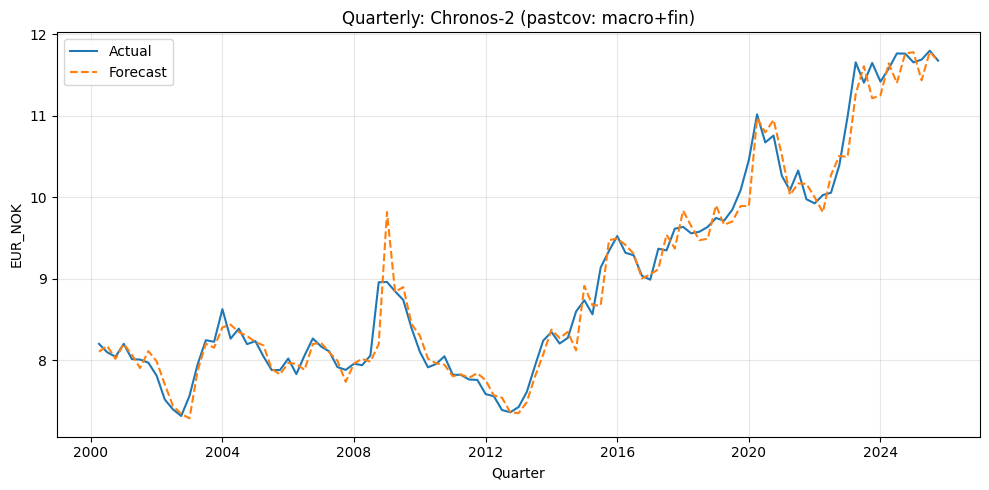

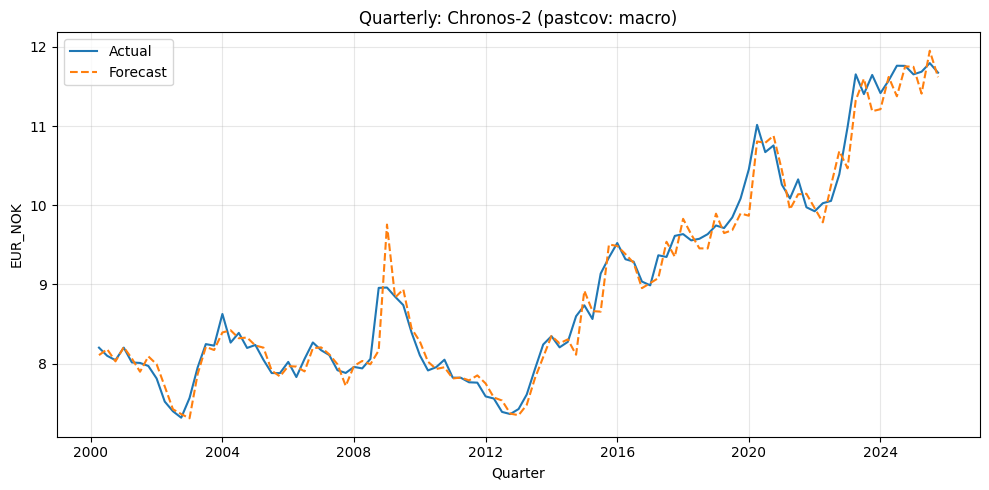


=== REGIME TABLES (QUARTERLY) ===

--- Full sample ---
                         Model  Obs     RMSE      MAE   DirAcc  DM_vs_RW  p_vs_RW  DM_n
Chronos-2 (pastcov: macro+fin)  103 0.203796 0.140577 0.774510 -1.512699 0.130356   102
    Chronos-2 (pastcov: macro)  103 0.208201 0.146160 0.813725 -1.425795 0.153927   102
        Chronos-2 (price-only)  103 0.214725 0.153961 0.745098 -0.921142 0.356977   102

--- Pre-GFC ---
                         Model  Obs     RMSE      MAE   DirAcc  DM_vs_RW  p_vs_RW  DM_n
        Chronos-2 (price-only)   30 0.111814 0.087078 0.896552 -3.349098 0.000811    29
    Chronos-2 (pastcov: macro)   30 0.112445 0.090436 0.896552 -3.621430 0.000293    29
Chronos-2 (pastcov: macro+fin)   30 0.113087 0.090410 0.896552 -3.550439 0.000385    29

--- GFC+ ---
                         Model  Obs     RMSE      MAE   DirAcc  DM_vs_RW  p_vs_RW  DM_n
Chronos-2 (pastcov: macro+fin)   47 0.223650 0.142664 0.717391 -0.064397 0.948654    46
    Chronos-2 (pastcov: macro)   

In [7]:
# ============================================================
# Chronos-2 (Quarterly) — A++ package (regimes + pairwise DM + NULL-centered block bootstrap)
# - Data: variables_daily.csv (daily wide)
# - Target: EUR_NOK
# - Cut: last business day of previous quarter
# - Forecast: daily from (cut+1) to (quarter end) -> quarterly mean over business days
# - Models (Chronos only):
#     1) price-only
#     2) pastcov: macro (macro publication lag = 20 business days, past-only in context)
#     3) pastcov: macro+fin
# - Obs = #quarter forecasts (often ~103 incl. last partial quarter); DM_n typically Obs-1
# ============================================================

# !pip -q install chronos-forecasting boto3 pandas numpy scikit-learn matplotlib requests certifi torch

from __future__ import annotations
import io, math, time, warnings
from dataclasses import dataclass
from typing import Optional, Dict, Tuple, List

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests, certifi
import torch

from sklearn.metrics import mean_absolute_error
from chronos import BaseChronosPipeline

warnings.filterwarnings("ignore")


# -----------------------------
# CONFIG
# -----------------------------
@dataclass
class CFG:
    url_daily: str = (
        "https://raw.githubusercontent.com/bredeespelid/"
        "Data_MasterOppgave/refs/heads/main/Variables/All_Variables/variables_daily.csv"
    )
    target: str = "EUR_NOK"

    fin_exog_cols: Tuple[str, ...] = ("Brent", "VIX", "StoxEurope", "SP500", "OSEBX", "OBX_Energy")
    macro_cols: Tuple[str, ...] = ("Q", "d_pi", "dI_t")

    macro_lag_bdays: int = 20  # publication lag in business days (macro only)

    # Quarterly definition
    q_freq: str = "Q-DEC"

    # Guards
    min_hist_days: int = 40
    max_horizon_days: int = 200  # guard for quarterly horizon in calendar days

    # Chronos
    chronos_model: str = "amazon/chronos-2"
    chronos_max_context: int = 2048
    chronos_fp16_on_cuda: bool = True

    # Bootstrap (A++)
    bootstrap_B: int = 800
    bootstrap_block: Optional[int] = None  # None -> auto ~ n^(1/3)

    # Download
    retries: int = 3
    timeout: int = 60


C = CFG()
USE_CUDA = bool(torch.cuda.is_available())
print(
    f"CUDA: {USE_CUDA} | device={'cuda' if USE_CUDA else 'cpu'} | macro_lag_bdays={C.macro_lag_bdays}"
)


# -----------------------------
# DOWNLOAD + LOAD
# -----------------------------
def download_csv_text(url: str, retries: int, timeout: int) -> str:
    last_err = None
    for k in range(1, retries + 1):
        try:
            r = requests.get(url, timeout=timeout, verify=certifi.where())
            r.raise_for_status()
            return r.text
        except Exception as e:
            last_err = e
            if k < retries:
                time.sleep(1.2 * k)
    raise RuntimeError(f"Download failed: {last_err}")


def load_daily_panel(url: str) -> pd.DataFrame:
    text = download_csv_text(url, retries=C.retries, timeout=C.timeout)
    df = pd.read_csv(io.StringIO(text))
    if "Date" not in df.columns:
        raise KeyError("Daily panel must contain column 'Date'.")

    df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
    df = df.dropna(subset=["Date"]).sort_values("Date").set_index("Date")

    for col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

    if C.target not in df.columns:
        raise KeyError(f"Target {C.target} not found in daily panel.")
    return df


def to_business_and_daily(df: pd.DataFrame) -> Tuple[pd.Series, pd.Series, pd.DataFrame]:
    cols = [C.target] + [c for c in (list(C.fin_exog_cols) + list(C.macro_cols)) if c in df.columns]
    df0 = df[cols].copy()

    # Business-day truth base
    S_b = df0[C.target].asfreq("B").ffill().astype(float)
    S_b.name = C.target

    # Calendar-day wide (context alignment)
    full_idx = pd.date_range(df0.index.min(), df0.index.max(), freq="D")
    DF_d = df0.reindex(full_idx).ffill()
    DF_d.index.name = "DATE"

    S_d = DF_d[C.target].astype(float).copy()
    S_d.name = C.target

    return S_b, S_d, DF_d


def last_trading_day(S_b: pd.Series, start: pd.Timestamp, end: pd.Timestamp) -> Optional[pd.Timestamp]:
    sl = S_b.loc[start:end]
    return sl.index[-1] if not sl.empty else None


# -----------------------------
# PERIOD + TRUTH
# -----------------------------
def period_range_from_series(idx: pd.DatetimeIndex, freq: str) -> pd.PeriodIndex:
    first = pd.Period(idx.min(), freq=freq)
    last  = pd.Period(idx.max(), freq=freq)
    return pd.period_range(first, last, freq=freq)


def truth_mean_bdays(S_b: pd.Series, p: pd.Period) -> Optional[float]:
    idx = S_b.index[(S_b.index >= p.start_time) & (S_b.index <= p.end_time)]
    if idx.size == 0:
        return None
    return float(S_b.loc[idx].mean())


# -----------------------------
# DM TEST + METRICS
# -----------------------------
def _normal_cdf(z: float) -> float:
    return 0.5 * (1.0 + math.erf(z / math.sqrt(2.0)))


def _dm_from_d(d: np.ndarray) -> float:
    d = np.asarray(d, dtype=float)
    n = d.size
    if n < 10:
        return float("nan")
    sd = float(d.std(ddof=1))
    if not np.isfinite(sd) or sd <= 0:
        return float("nan")
    return float(d.mean() / (sd / math.sqrt(n)))


def dm_vs_rw(df_eval: pd.DataFrame) -> Tuple[float, float, int]:
    core = df_eval.dropna(subset=["y_true", "y_pred"]).copy()
    core["rw_pred"] = core["y_true"].shift(1)
    core = core.dropna(subset=["rw_pred"])
    if len(core) < 10:
        return float("nan"), float("nan"), int(len(core))

    e_m = core["y_true"].to_numpy() - core["y_pred"].to_numpy()
    e_r = core["y_true"].to_numpy() - core["rw_pred"].to_numpy()
    d = (e_m**2) - (e_r**2)

    dm = _dm_from_d(d)
    p  = float(2.0 * (1.0 - _normal_cdf(abs(dm)))) if np.isfinite(dm) else float("nan")
    return float(dm), float(p), int(len(d))


def eval_metrics_forecast(df_eval: pd.DataFrame) -> Dict[str, float]:
    core = df_eval.dropna(subset=["y_true", "y_pred"]).copy()
    n = int(len(core))
    if n == 0:
        return dict(obs=0, rmse=np.nan, mae=np.nan, diracc=np.nan)

    err = core["y_true"] - core["y_pred"]
    rmse = float(np.sqrt(np.mean(err**2)))
    mae  = float(mean_absolute_error(core["y_true"], core["y_pred"]))

    core["y_prev"] = core["y_true"].shift(1)
    mask = core["y_prev"].notna()
    if mask.any():
        dir_true = np.sign(core.loc[mask, "y_true"] - core.loc[mask, "y_prev"])
        dir_pred = np.sign(core.loc[mask, "y_pred"] - core.loc[mask, "y_prev"])
        diracc = float((dir_true.values == dir_pred.values).mean())
    else:
        diracc = np.nan

    return dict(obs=n, rmse=rmse, mae=mae, diracc=diracc)


def dm_pairwise(df_a: pd.DataFrame, df_b: pd.DataFrame) -> Tuple[float, float, int]:
    df = pd.concat({"y": df_a["y_true"], "a": df_a["y_pred"], "b": df_b["y_pred"]}, axis=1).dropna()
    if len(df) < 10:
        return float("nan"), float("nan"), int(len(df))

    e_a = df["y"].to_numpy() - df["a"].to_numpy()
    e_b = df["y"].to_numpy() - df["b"].to_numpy()
    d = (e_a**2) - (e_b**2)

    dm = _dm_from_d(d)
    p  = float(2.0 * (1.0 - _normal_cdf(abs(dm)))) if np.isfinite(dm) else float("nan")
    return float(dm), float(p), int(len(d))


# -----------------------------
# NULL-CENTERED BLOCK BOOTSTRAP (A++)
# -----------------------------
def block_bootstrap_dm_vs_rw_null_centered(
    df_eval: pd.DataFrame,
    B: int,
    block: Optional[int],
    seed: int = 42,
    one_sided: bool = True,  # test "better than RW" => DM < 0
) -> Dict[str, float]:
    core = df_eval.dropna(subset=["y_true", "y_pred"]).copy()
    core["rw_pred"] = core["y_true"].shift(1)
    core = core.dropna(subset=["rw_pred"])

    n = int(len(core))
    if n < 30:
        return {"n": n, "dm_hat": np.nan, "p_boot": np.nan, "block": np.nan}

    e_m = core["y_true"].to_numpy() - core["y_pred"].to_numpy()
    e_r = core["y_true"].to_numpy() - core["rw_pred"].to_numpy()
    d = (e_m**2) - (e_r**2)

    dm_hat = _dm_from_d(d)
    if not np.isfinite(dm_hat):
        return {"n": n, "dm_hat": float("nan"), "p_boot": float("nan"), "block": float("nan")}

    # null-centering
    d0 = d - d.mean()

    # block length
    if block is None:
        b = int(round(n ** (1/3)))
        b = max(2, min(b, max(2, n // 2)))
    else:
        b = int(block)
        b = max(2, min(b, max(2, n // 2)))

    rng = np.random.default_rng(seed)
    starts = np.arange(0, n - b + 1)
    if starts.size == 0:
        return {"n": n, "dm_hat": float(dm_hat), "p_boot": np.nan, "block": float(b)}

    dm_boot = np.empty(B, dtype=float)
    dm_boot[:] = np.nan

    for i in range(B):
        idx = []
        while len(idx) < n:
            s = int(rng.choice(starts))
            idx.extend(range(s, s + b))
        idx = idx[:n]
        d_s = d0[np.array(idx, dtype=int)]
        dm_boot[i] = _dm_from_d(d_s)

    dm_boot = dm_boot[np.isfinite(dm_boot)]
    if dm_boot.size < 50:
        return {"n": n, "dm_hat": float(dm_hat), "p_boot": np.nan, "block": float(b)}

    if one_sided:
        # better than RW corresponds to dm_hat < 0
        if dm_hat < 0:
            p_boot = float(np.mean(dm_boot <= dm_hat))
        else:
            p_boot = float(np.mean(dm_boot >= dm_hat))
    else:
        p_boot = float(np.mean(np.abs(dm_boot) >= abs(dm_hat)))

    return {"n": n, "dm_hat": float(dm_hat), "p_boot": float(p_boot), "block": float(b)}


# -----------------------------
# CHRONOS PIPELINE
# -----------------------------
def build_chronos_pipeline() -> BaseChronosPipeline:
    if USE_CUDA and C.chronos_fp16_on_cuda:
        return BaseChronosPipeline.from_pretrained(C.chronos_model, device_map="cuda", dtype=torch.float16)
    if USE_CUDA:
        return BaseChronosPipeline.from_pretrained(C.chronos_model, device_map="cuda", dtype=torch.float32)
    return BaseChronosPipeline.from_pretrained(C.chronos_model, device_map="cpu", dtype=torch.float32)


def chronos_forecast_price_only(pipe: BaseChronosPipeline, ctx_values: np.ndarray, H: int) -> np.ndarray:
    ctx = np.asarray(ctx_values, dtype=float).ravel()[-C.chronos_max_context:]
    ts = pd.date_range("2000-01-01", periods=len(ctx), freq="D")
    df = pd.DataFrame({"item_id": "series_1", "timestamp": ts, "target": ctx})

    with torch.inference_mode():
        pred = pipe.predict_df(df, prediction_length=H, quantile_levels=[0.5])

    pred = pred.sort_values("timestamp")
    if "0.5" in pred.columns:
        return pred["0.5"].to_numpy(dtype=float)[:H]
    if "predictions" in pred.columns:
        return pred["predictions"].to_numpy(dtype=float)[:H]
    raise RuntimeError(f"Unsupported Chronos output columns: {list(pred.columns)}")


def _make_hist_wide_with_macro_lag(DF_d: pd.DataFrame, cut: pd.Timestamp) -> pd.DataFrame:
    """
    Past-only macro in context: after lag_cut we only allow values observed up to lag_cut.
    """
    hist = DF_d.loc[:cut].copy()
    lag_cut = cut - pd.tseries.offsets.BDay(C.macro_lag_bdays)

    for c in C.macro_cols:
        if c in hist.columns:
            hist[c] = DF_d[c].loc[:lag_cut].reindex(hist.index).ffill()

    return hist


def make_pastcov_context(hist_wide: pd.DataFrame, cov_cols: List[str]) -> pd.DataFrame:
    ctx = pd.DataFrame({
        "timestamp": hist_wide.index,
        "item_id": C.target,
        "target": hist_wide[C.target].astype(float).values,
    })
    for c in cov_cols:
        ctx[c] = hist_wide[c].astype(float).values
    return ctx.sort_values("timestamp")


def chronos_forecast_pastcov(pipe: BaseChronosPipeline, context_df: pd.DataFrame, H: int) -> pd.DataFrame:
    with torch.inference_mode():
        pred = pipe.predict_df(
            context_df,
            prediction_length=H,
            quantile_levels=[0.5],
            id_column="item_id",
            timestamp_column="timestamp",
            target="target",
            predict_batches_jointly=False,
        )

    pred = pred.sort_values("timestamp")
    if "0.5" in pred.columns:
        return pred.rename(columns={"0.5": "y_pred"})[["item_id", "timestamp", "y_pred"]].copy()
    if "predictions" in pred.columns:
        return pred.rename(columns={"predictions": "y_pred"})[["item_id", "timestamp", "y_pred"]].copy()
    raise RuntimeError(f"Unsupported Chronos output columns: {list(pred.columns)}")


# -----------------------------
# WALK-FORWARD (QUARTERLY)
# -----------------------------
def walk_forward_chronos_quarterly_price_only(S_b: pd.Series, S_d: pd.Series, pipe: BaseChronosPipeline) -> pd.DataFrame:
    quarters = period_range_from_series(S_b.index, freq=C.q_freq)
    rows, dropped = [], {}

    for q in quarters:
        prev_q = q - 1
        cut = last_trading_day(S_b, prev_q.start_time, prev_q.end_time)
        if cut is None:
            dropped[str(q)] = "no_cut_in_prev_quarter"
            continue

        hist = S_d.loc[:cut].dropna()
        if len(hist) < C.min_hist_days:
            dropped[str(q)] = f"hist<{C.min_hist_days}"
            continue

        y_true = truth_mean_bdays(S_b, q)
        if y_true is None:
            dropped[str(q)] = "no_truth"
            continue

        # horizon: from cut+1 to quarter end (same logic as monthly)
        f_start = cut + pd.Timedelta(days=1)
        f_end = q.end_time
        H = int((f_end.date() - f_start.date()).days + 1)
        if H <= 0 or H > C.max_horizon_days:
            dropped[str(q)] = f"horizon_invalid(H={H})"
            continue

        pf = chronos_forecast_price_only(pipe, hist.values, H)
        f_idx = pd.date_range(f_start, periods=H, freq="D")
        pred_daily = pd.Series(pf, index=f_idx)

        idx_b = S_b.index[(S_b.index >= q.start_time) & (S_b.index <= q.end_time)]
        pred_b = pred_daily.reindex(idx_b, method=None)
        if pred_b.isna().all():
            dropped[str(q)] = "no_overlap_pred_B_days"
            continue

        y_pred = float(pred_b.dropna().mean())
        rows.append({"period": q, "cut": cut, "y_true": y_true, "y_pred": y_pred})

    df = pd.DataFrame(rows).set_index("period").sort_index()
    if dropped:
        print("\nDropped quarters and reasons (Quarterly):")
        for k, v in dropped.items():
            print(f"  {k}: {v}")
    return df


def walk_forward_chronos_quarterly_pastcov(
    S_b: pd.Series, DF_d: pd.DataFrame, pipe: BaseChronosPipeline, cov_cols: List[str]
) -> pd.DataFrame:
    quarters = period_range_from_series(S_b.index, freq=C.q_freq)
    rows, dropped = [], {}

    for q in quarters:
        prev_q = q - 1
        cut = last_trading_day(S_b, prev_q.start_time, prev_q.end_time)
        if cut is None:
            dropped[str(q)] = "no_cut_in_prev_quarter"
            continue

        hist_wide = _make_hist_wide_with_macro_lag(DF_d, cut).dropna(subset=[C.target])
        if len(hist_wide) < C.min_hist_days:
            dropped[str(q)] = f"hist<{C.min_hist_days}"
            continue

        y_true = truth_mean_bdays(S_b, q)
        if y_true is None:
            dropped[str(q)] = "no_truth"
            continue

        # horizon: from cut+1 to quarter end (same logic as monthly)
        f_start = cut + pd.Timedelta(days=1)
        f_end = q.end_time
        H = int((f_end.date() - f_start.date()).days + 1)
        if H <= 0 or H > C.max_horizon_days:
            dropped[str(q)] = f"horizon_invalid(H={H})"
            continue

        context_df = make_pastcov_context(hist_wide, cov_cols)
        pred_df = chronos_forecast_pastcov(pipe, context_df, H)

        f_idx = pd.date_range(f_start, periods=H, freq="D")
        pred_daily = pd.Series(index=f_idx, dtype=float)

        tmp = pred_df[pred_df["item_id"] == C.target].set_index("timestamp")["y_pred"]
        common = tmp.index.intersection(pred_daily.index)
        pred_daily.loc[common] = tmp.loc[common]
        pred_daily = pred_daily.ffill()

        idx_b = S_b.index[(S_b.index >= q.start_time) & (S_b.index <= q.end_time)]
        pred_b = pred_daily.reindex(idx_b, method=None)
        if pred_b.isna().all():
            dropped[str(q)] = "no_overlap_pred_B_days"
            continue

        y_pred = float(pred_b.dropna().mean())
        rows.append({"period": q, "cut": cut, "y_true": y_true, "y_pred": y_pred})

    df = pd.DataFrame(rows).set_index("period").sort_index()
    if dropped:
        print("\nDropped quarters and reasons (Quarterly pastcov):")
        for k, v in dropped.items():
            print(f"  {k}: {v}")
    return df


# -----------------------------
# SUMMARY TABLE + REGIMES
# -----------------------------
@dataclass(frozen=True)
class Regime:
    name: str
    start: str
    end: str


REGIMES = [
    Regime("Full sample", "1900-01-01", "2100-01-01"),
    Regime("Pre-GFC", "2000-01-01", "2007-12-31"),
    Regime("GFC+", "2008-01-01", "2019-12-31"),
    Regime("COVID+", "2020-01-01", "2021-12-31"),
    Regime("Energy+FX shock", "2022-01-01", "2100-01-01"),
]


def filter_eval_by_regime(df_eval: pd.DataFrame, reg: Regime) -> pd.DataFrame:
    ts = df_eval.index.to_timestamp(how="end")
    mask = (ts >= pd.Timestamp(reg.start)) & (ts <= pd.Timestamp(reg.end))
    return df_eval.loc[mask]


def summary_table(models: Dict[str, pd.DataFrame]) -> pd.DataFrame:
    rows = []
    for name, df_eval in models.items():
        st = eval_metrics_forecast(df_eval)
        dm, p, n_dm = dm_vs_rw(df_eval)
        rows.append({
            "Model": name,
            "Obs": st["obs"],
            "RMSE": st["rmse"],
            "MAE": st["mae"],
            "DirAcc": st["diracc"],
            "DM_vs_RW": dm,
            "p_vs_RW": p,
            "DM_n": n_dm,
        })
    return pd.DataFrame(rows).sort_values("RMSE")


def plot_actual_vs_pred(df_eval: pd.DataFrame, title: str):
    core = df_eval.dropna(subset=["y_true", "y_pred"]).copy()
    if core.empty:
        return
    x = core.index.to_timestamp()
    plt.figure(figsize=(10, 5))
    plt.plot(x, core["y_true"], label="Actual")
    plt.plot(x, core["y_pred"], "--", label="Forecast")
    plt.title(title)
    plt.xlabel("Quarter")
    plt.ylabel(C.target)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()


# -----------------------------
# RUN (QUARTERLY)
# -----------------------------
df_daily = load_daily_panel(C.url_daily)
S_b, S_d, DF_d = to_business_and_daily(df_daily)

print(f"Daily panel: {df_daily.index.min().date()} → {df_daily.index.max().date()} | rows={len(df_daily)}")
print(f"S_b: {S_b.index.min().date()} → {S_b.index.max().date()} | n={len(S_b)}")
print(f"DF_d: {DF_d.index.min().date()} → {DF_d.index.max().date()} | rows={len(DF_d)}")

pipe = build_chronos_pipeline()

macro_cov = [c for c in C.macro_cols if c in DF_d.columns]
fin_cov   = [c for c in C.fin_exog_cols if c in DF_d.columns]

models = {
    "Chronos-2 (price-only)": walk_forward_chronos_quarterly_price_only(S_b, S_d, pipe),
    "Chronos-2 (pastcov: macro)": walk_forward_chronos_quarterly_pastcov(S_b, DF_d, pipe, cov_cols=macro_cov),
    "Chronos-2 (pastcov: macro+fin)": walk_forward_chronos_quarterly_pastcov(S_b, DF_d, pipe, cov_cols=(macro_cov + fin_cov)),
}

tbl = summary_table(models)
print("\n=== QUARTERLY (Chronos-2) ===")
print(tbl.to_string(index=False))

# Plot top-2 by RMSE
top2 = tbl["Model"].head(2).tolist()
for m in top2:
    plot_actual_vs_pred(models[m], f"Quarterly: {m}")

# Regime tables
print("\n=== REGIME TABLES (QUARTERLY) ===")
for reg in REGIMES:
    sub = {k: filter_eval_by_regime(v, reg) for k, v in models.items()}
    t = summary_table(sub)
    print(f"\n--- {reg.name} ---")
    print(t.to_string(index=False))

# Pairwise DM for top-2
if len(top2) >= 2:
    dm, p, n = dm_pairwise(models[top2[0]], models[top2[1]])
    print("\n=== Pairwise DM (MSE): Quarterly top-2 ===")
    print(f"{top2[0]} vs {top2[1]}")
    print(f"DM-stat: {dm:.4f} | p-value: {p:.4f} | N={n}")

# Null-centered block bootstrap DM vs RW (top-2, one-sided)
print("\n=== Null-centered block-bootstrap DM vs RW (QUARTERLY, top-2, one-sided) ===")
for m in top2:
    res = block_bootstrap_dm_vs_rw_null_centered(
        models[m],
        B=C.bootstrap_B,
        block=C.bootstrap_block,   # None -> auto
        seed=42,
        one_sided=True
    )
    print(f"{m}: DM_hat={res['dm_hat']:.4f} | p_boot={res['p_boot']:.4f} | DM_n={res['n']} | block={int(res['block'])}")


## XGBoost

Macro publication lag (B-days): 20
Daily panel: 2000-01-31 -> 2025-11-10 | rows=9416
S_b: 2000-01-31 -> 2025-11-10 | n=6726
DF_d: 2000-01-31 -> 2025-11-10 | rows=9416

Dropped months and reasons:
  2000-01: no_cut_in_prev_month
  2000-02: hist_too_short
  2000-03: hist_too_short

Dropped months and reasons:
  2000-01: no_cut_in_prev_month
  2000-02: hist_too_short
  2000-03: hist_too_short

Dropped months and reasons:
  2000-01: no_cut_in_prev_month
  2000-02: hist_too_short
  2000-03: hist_too_short

=== MONTHLY (XGB only) ===
                     Model  Obs     RMSE      MAE   DirAcc  DM_vs_RW  p_vs_RW  DM_n
 XGB Recursive (macro+fin)  308 0.148899 0.101391 0.654723 -2.603868 0.009218   307
     XGB Recursive (macro)  308 0.151414 0.102926 0.667752 -2.087793 0.036816   307
XGB Recursive (price-only)  308 0.154488 0.105596 0.661238 -1.482931 0.138093   307


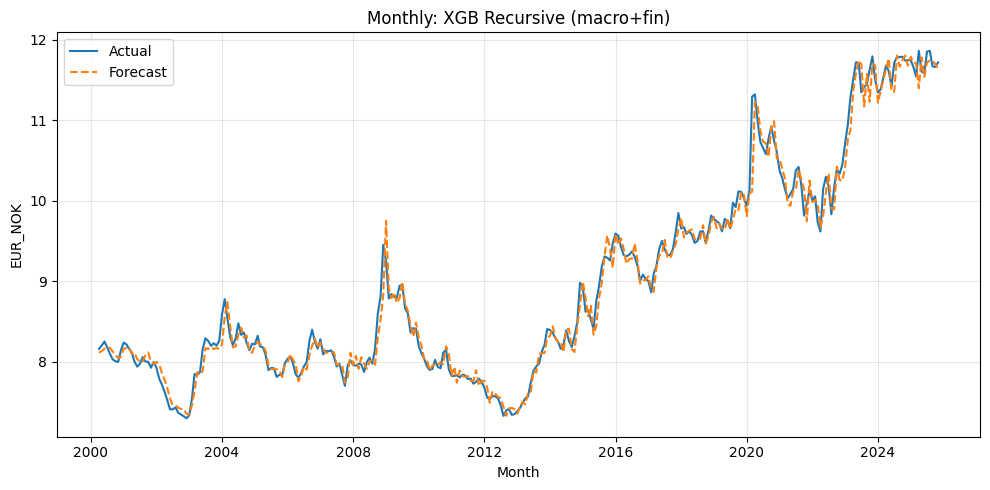

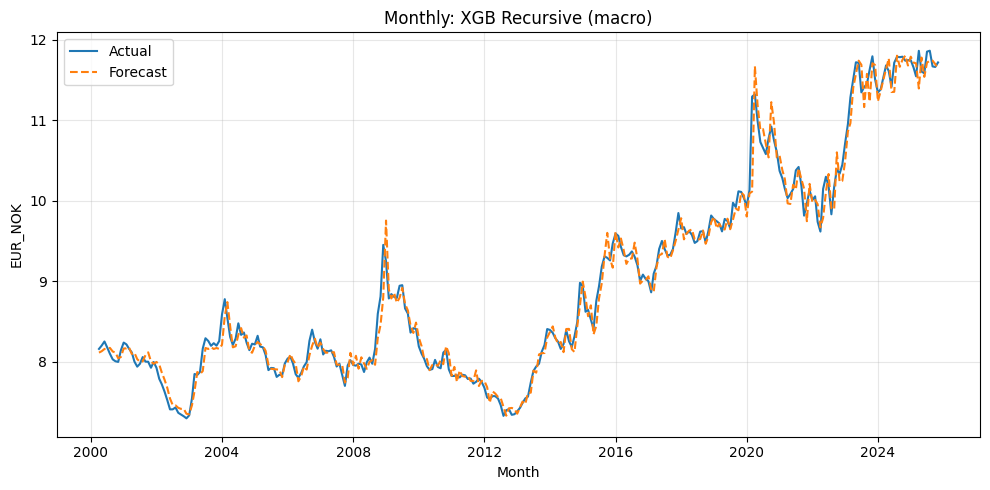


=== REGIME TABLES (MONTHLY) ===

--- Full sample ---
                     Model  Obs     RMSE      MAE   DirAcc  DM_vs_RW  p_vs_RW  DM_n
 XGB Recursive (macro+fin)  308 0.148899 0.101391 0.654723 -2.603868 0.009218   307
     XGB Recursive (macro)  308 0.151414 0.102926 0.667752 -2.087793 0.036816   307
XGB Recursive (price-only)  308 0.154488 0.105596 0.661238 -1.482931 0.138093   307

--- Pre-GFC ---
                     Model  Obs     RMSE      MAE   DirAcc  DM_vs_RW  p_vs_RW  DM_n
XGB Recursive (price-only)   92 0.098971 0.078125 0.648352 -2.680774 0.007345    91
 XGB Recursive (macro+fin)   92 0.099999 0.077128 0.670330 -2.485525 0.012936    91
     XGB Recursive (macro)   92 0.100330 0.077542 0.670330 -2.418978 0.015564    91

--- GFC+ ---
                     Model  Obs     RMSE      MAE   DirAcc  DM_vs_RW  p_vs_RW  DM_n
 XGB Recursive (macro+fin)  143 0.127763 0.090891 0.676056 -1.701040 0.088936   142
     XGB Recursive (macro)  143 0.129689 0.090144 0.676056 -1.476313 0.1398

In [ ]:
# ============================================================
# XGBoost (Monthly) - A++: regimes + pairwise DM + NULL-centered block bootstrap
# - Data: variables_daily.csv (daily wide)
# - Target: EUR_NOK
# - Cut: last business day of previous month
# - Forecast: recursive daily from (cut+1) to (month end) -> monthly mean over business days
# - Models:
#     1) XGB Recursive (price-only)
#     2) XGB Recursive (macro)        [past-only, publication lag in B-days]
#     3) XGB Recursive (macro+fin)    [past-only macro + fin as-of t-1]
# - Obs target: around 308 (depends on data end)
# ============================================================

# !pip -q install pandas numpy scikit-learn matplotlib requests certifi joblib xgboost

from __future__ import annotations
import io, math, time, warnings
from dataclasses import dataclass
from typing import Optional, Dict, Tuple, List

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests, certifi

from sklearn.metrics import mean_absolute_error
from joblib import Parallel, delayed
from xgboost import XGBRegressor

warnings.filterwarnings("ignore")


# -----------------------------
# CONFIG
# -----------------------------
@dataclass
class CFG:
    url_daily: str = (
        "https://raw.githubusercontent.com/bredeespelid/"
        "Data_MasterOppgave/refs/heads/main/Variables/All_Variables/variables_daily.csv"
    )
    target: str = "EUR_NOK"

    fin_cols: Tuple[str, ...] = ("Brent", "VIX", "StoxEurope", "SP500", "OSEBX", "OBX_Energy")
    macro_cols: Tuple[str, ...] = ("Q", "d_pi", "dI_t")

    macro_lag_bdays: int = 20  # publication lag in business days

    # Walk-forward rules
    min_hist_days: int = 40
    max_lags: int = 20
    max_horizon_days: int = 70  # allow small spillover around month end

    # XGB hyperparams (fixed cap)
    n_estimators: int = 150
    learning_rate: float = 0.04
    max_depth: int = 6
    min_child_weight: float = 7.0
    subsample: float = 0.6
    colsample_bytree: float = 1.0
    gamma: float = 0.05
    reg_alpha: float = 0.2
    reg_lambda: float = 0.5
    tree_method: str = "hist"
    objective: str = "reg:squarederror"
    eval_metric: str = "rmse"
    seed: int = 42

    # A++ bootstrap
    bootstrap_B: int = 800
    bootstrap_block: Optional[int] = None  # None -> auto ~ n^(1/3)

    # Download
    retries: int = 3
    timeout: int = 60

C = CFG()
print(f"Macro publication lag (B-days): {C.macro_lag_bdays}")


# -----------------------------
# DOWNLOAD + LOAD
# -----------------------------
def download_csv_text(url: str, retries: int, timeout: int) -> str:
    last_err = None
    for k in range(1, retries + 1):
        try:
            r = requests.get(url, timeout=timeout, verify=certifi.where())
            r.raise_for_status()
            return r.text
        except Exception as e:
            last_err = e
            if k < retries:
                time.sleep(1.2 * k)
    raise RuntimeError(f"Download failed: {last_err}")


def load_daily_panel(url: str) -> pd.DataFrame:
    text = download_csv_text(url, retries=C.retries, timeout=C.timeout)
    df = pd.read_csv(io.StringIO(text))
    if "Date" not in df.columns:
        raise KeyError("Daily panel must contain column 'Date'.")
    df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
    df = df.dropna(subset=["Date"]).sort_values("Date").set_index("Date")

    for col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

    if C.target not in df.columns:
        raise KeyError(f"Target {C.target} not found in daily panel.")
    return df


def to_business_and_daily_wide(df: pd.DataFrame) -> Tuple[pd.Series, pd.DataFrame]:
    keep = [C.target]
    keep += [c for c in (list(C.fin_cols) + list(C.macro_cols)) if c in df.columns]
    df0 = df[keep].copy()

    # Business-day truth base
    S_b = df0[C.target].asfreq("B").ffill().astype(float)
    S_b.name = C.target

    # Daily calendar (model inputs)
    full_idx = pd.date_range(df0.index.min(), df0.index.max(), freq="D")
    DF_d = df0.reindex(full_idx).ffill()
    DF_d.index.name = "DATE"
    return S_b, DF_d


def last_trading_day(S_b: pd.Series, start: pd.Timestamp, end: pd.Timestamp) -> Optional[pd.Timestamp]:
    sl = S_b.loc[start:end]
    return sl.index[-1] if not sl.empty else None


# -----------------------------
# PERIOD + TRUTH
# -----------------------------
def period_range_from_series(idx: pd.DatetimeIndex, freq: str) -> pd.PeriodIndex:
    first = pd.Period(idx.min(), freq=freq)
    last  = pd.Period(idx.max(), freq=freq)
    return pd.period_range(first, last, freq=freq)


def truth_mean_bdays(S_b: pd.Series, p: pd.Period) -> Optional[float]:
    idx = S_b.index[(S_b.index >= p.start_time) & (S_b.index <= p.end_time)]
    if idx.size == 0:
        return None
    return float(S_b.loc[idx].mean())


# -----------------------------
# FEATURES (daily one-step)
# -----------------------------
def _feature_order(variant: str, DF_cols: List[str]) -> List[str]:
    feats = [f"lag{k}" for k in range(1, C.max_lags + 1)]

    if variant in ("macro", "macro+fin"):
        for c in C.macro_cols:
            if c in DF_cols:
                feats.append(f"macro_{c}")

    if variant == "macro+fin":
        for c in C.fin_cols:
            if c in DF_cols:
                feats.append(f"fin_{c}")

    return feats


def macro_asof_series(DF_d: pd.DataFrame, col: str, lag_bdays: int) -> pd.Series:
    lagged_idx = DF_d.index - pd.tseries.offsets.BDay(lag_bdays)
    vals = DF_d[col].reindex(lagged_idx).to_numpy()
    return pd.Series(vals, index=DF_d.index, name=f"{col}_asofB{lag_bdays}")


def make_daily_supervised(DF_hist: pd.DataFrame, variant: str) -> Tuple[np.ndarray, np.ndarray, List[str]]:
    df = DF_hist.copy()
    y = df[C.target].astype(float)

    Xdf = pd.DataFrame(index=df.index)
    for k in range(1, C.max_lags + 1):
        Xdf[f"lag{k}"] = y.shift(k)

    if variant in ("macro", "macro+fin"):
        for c in C.macro_cols:
            if c in df.columns:
                m_asof = macro_asof_series(df, c, C.macro_lag_bdays)
                Xdf[f"macro_{c}"] = m_asof.shift(1)

    if variant == "macro+fin":
        for c in C.fin_cols:
            if c in df.columns:
                Xdf[f"fin_{c}"] = df[c].astype(float).shift(1)

    out = pd.concat([y.rename("y"), Xdf], axis=1).dropna()
    if len(out) < 20:
        raise ValueError("Too few observations after lagging.")

    feat_names = _feature_order(variant, DF_hist.columns.tolist())
    X = out[feat_names].to_numpy(dtype=float)
    y_target = out["y"].to_numpy(dtype=float)
    return X, y_target, feat_names


def fit_xgb_one_step(DF_hist: pd.DataFrame, variant: str) -> Tuple[XGBRegressor, List[str]]:
    X, y, feat_names = make_daily_supervised(DF_hist, variant)
    model = XGBRegressor(
        n_estimators=C.n_estimators,
        learning_rate=C.learning_rate,
        max_depth=C.max_depth,
        min_child_weight=C.min_child_weight,
        subsample=C.subsample,
        colsample_bytree=C.colsample_bytree,
        gamma=C.gamma,
        reg_alpha=C.reg_alpha,
        reg_lambda=C.reg_lambda,
        objective=C.objective,
        eval_metric=C.eval_metric,
        tree_method=C.tree_method,
        random_state=C.seed,
        n_jobs=1,
    )
    model.fit(X, y)
    return model, feat_names


def _frozen_exogs_at_cut(DF_hist: pd.DataFrame, variant: str, cut: pd.Timestamp) -> Tuple[Dict[str, float], Dict[str, float]]:
    macro_const: Dict[str, float] = {}
    fin_const: Dict[str, float] = {}

    if variant in ("macro", "macro+fin"):
        lag_cut = cut - pd.tseries.offsets.BDay(C.macro_lag_bdays)
        for c in C.macro_cols:
            if c in DF_hist.columns:
                s = DF_hist[c].loc[:lag_cut].dropna()
                macro_const[c] = float(s.iloc[-1]) if not s.empty else np.nan

    if variant == "macro+fin":
        for c in C.fin_cols:
            if c in DF_hist.columns:
                s = DF_hist[c].loc[:cut].dropna()
                fin_const[c] = float(s.iloc[-1]) if not s.empty else np.nan

    return macro_const, fin_const


def recursive_daily_forecast(
    model: XGBRegressor,
    DF_hist: pd.DataFrame,
    H: int,
    variant: str,
    cut: pd.Timestamp,
    feat_names: List[str],
) -> pd.Series:
    hist_y = DF_hist[C.target].astype(float).values.tolist()
    macro_const, fin_const = _frozen_exogs_at_cut(DF_hist, variant, cut)

    preds = []
    for _ in range(H):
        if len(hist_y) < C.max_lags:
            raise ValueError("Not enough history for lag features.")

        row = {}
        last_lags = hist_y[-C.max_lags:][::-1]  # [t-1,...,t-L]
        for k in range(1, C.max_lags + 1):
            row[f"lag{k}"] = float(last_lags[k - 1])

        if variant in ("macro", "macro+fin"):
            for c in C.macro_cols:
                if f"macro_{c}" in feat_names:
                    row[f"macro_{c}"] = float(macro_const.get(c, np.nan))

        if variant == "macro+fin":
            for c in C.fin_cols:
                if f"fin_{c}" in feat_names:
                    row[f"fin_{c}"] = float(fin_const.get(c, np.nan))

        x = np.array([row[n] for n in feat_names], dtype=float).reshape(1, -1)
        yhat = float(model.predict(x)[0])
        preds.append(yhat)
        hist_y.append(yhat)

    return pd.Series(preds, dtype=float)


# -----------------------------
# WALK-FORWARD MONTHLY
# -----------------------------
def walk_forward_xgb_monthly(S_b: pd.Series, DF_d: pd.DataFrame, variant: str, n_jobs_outer: int = -1) -> pd.DataFrame:
    months = period_range_from_series(S_b.index, freq="M")

    def _one(m: pd.Period):
        prev_m = m - 1
        cut = last_trading_day(S_b, prev_m.start_time, prev_m.end_time)
        if cut is None:
            return (m, None, "no_cut_in_prev_month")

        DF_hist = DF_d.loc[:cut].copy()
        if len(DF_hist) < C.min_hist_days or len(DF_hist) <= C.max_lags:
            return (m, None, "hist_too_short")

        y_true = truth_mean_bdays(S_b, m)
        if y_true is None:
            return (m, None, "no_truth")

        # IMPORTANT: horizon must be from cut+1 to month end (not month length)
        f_start = cut + pd.Timedelta(days=1)
        f_end = m.end_time
        H = int((f_end.date() - f_start.date()).days + 1)
        if H <= 0 or H > C.max_horizon_days:
            return (m, None, f"horizon_invalid(H={H})")

        model, feat_names = fit_xgb_one_step(DF_hist, variant)
        pf = recursive_daily_forecast(model, DF_hist, H, variant, cut, feat_names)

        f_idx = pd.date_range(f_start, periods=H, freq="D")
        pred_daily = pd.Series(pf.values, index=f_idx)

        idx_b = S_b.index[(S_b.index >= m.start_time) & (S_b.index <= m.end_time)]
        pred_b = pred_daily.reindex(idx_b, method=None)
        if pred_b.isna().all():
            return (m, None, "no_overlap_pred_B_days")

        y_pred = float(pred_b.dropna().mean())
        return (m, {"period": m, "cut": cut, "y_true": y_true, "y_pred": y_pred}, None)

    res = Parallel(n_jobs=n_jobs_outer, backend="loky")(delayed(_one)(m) for m in months)

    rows, dropped = [], {}
    for m, row, reason in res:
        if row is not None:
            rows.append(row)
        else:
            dropped[str(m)] = reason or "unknown"

    df = pd.DataFrame(rows).set_index("period").sort_index()
    if dropped:
        print("\nDropped months and reasons:")
        for k, v in dropped.items():
            print(f"  {k}: {v}")
    return df


# -----------------------------
# METRICS + DM + BOOTSTRAP
# -----------------------------
def _normal_cdf(z: float) -> float:
    return 0.5 * (1.0 + math.erf(z / math.sqrt(2.0)))


def eval_metrics(df_eval: pd.DataFrame) -> Dict[str, float]:
    core = df_eval.dropna(subset=["y_true", "y_pred"]).copy()
    n = int(len(core))
    if n == 0:
        return dict(obs=0, rmse=np.nan, mae=np.nan, diracc=np.nan)

    err = core["y_true"] - core["y_pred"]
    rmse = float(np.sqrt(np.mean(err**2)))
    mae = float(mean_absolute_error(core["y_true"], core["y_pred"]))

    core["y_prev"] = core["y_true"].shift(1)
    mask = core["y_prev"].notna()
    if mask.any():
        dir_true = np.sign(core.loc[mask, "y_true"] - core.loc[mask, "y_prev"])
        dir_pred = np.sign(core.loc[mask, "y_pred"] - core.loc[mask, "y_prev"])
        diracc = float((dir_true.values == dir_pred.values).mean())
    else:
        diracc = np.nan

    return dict(obs=n, rmse=rmse, mae=mae, diracc=diracc)


def _dm_from_d(d: np.ndarray) -> float:
    d = np.asarray(d, dtype=float)
    n = d.size
    if n < 10:
        return float("nan")
    sd = float(d.std(ddof=1))
    if not np.isfinite(sd) or sd <= 0:
        return float("nan")
    return float(d.mean() / (sd / math.sqrt(n)))


def dm_vs_rw(df_eval: pd.DataFrame) -> Tuple[float, float, int]:
    core = df_eval.dropna(subset=["y_true", "y_pred"]).copy()
    core["rw_pred"] = core["y_true"].shift(1)
    core = core.dropna(subset=["rw_pred"])
    if len(core) < 10:
        return float("nan"), float("nan"), int(len(core))

    e_m = core["y_true"].to_numpy() - core["y_pred"].to_numpy()
    e_r = core["y_true"].to_numpy() - core["rw_pred"].to_numpy()
    d = (e_m**2) - (e_r**2)

    dm = _dm_from_d(d)
    p = float(2.0 * (1.0 - _normal_cdf(abs(dm)))) if np.isfinite(dm) else float("nan")
    return float(dm), float(p), int(len(d))


def dm_pairwise(df_a: pd.DataFrame, df_b: pd.DataFrame) -> Tuple[float, float, int]:
    df = pd.concat({"y": df_a["y_true"], "a": df_a["y_pred"], "b": df_b["y_pred"]}, axis=1).dropna()
    if len(df) < 10:
        return float("nan"), float("nan"), int(len(df))
    e_a = df["y"].to_numpy() - df["a"].to_numpy()
    e_b = df["y"].to_numpy() - df["b"].to_numpy()
    d = (e_a**2) - (e_b**2)
    dm = _dm_from_d(d)
    p = float(2.0 * (1.0 - _normal_cdf(abs(dm)))) if np.isfinite(dm) else float("nan")
    return float(dm), float(p), int(len(d))


def block_bootstrap_dm_vs_rw_null_centered(
    df_eval: pd.DataFrame,
    B: int,
    block: Optional[int],
    seed: int = 42,
    one_sided: bool = True,  # "better than RW" => DM < 0
) -> Dict[str, float]:
    core = df_eval.dropna(subset=["y_true", "y_pred"]).copy()
    core["rw_pred"] = core["y_true"].shift(1)
    core = core.dropna(subset=["rw_pred"])

    n = int(len(core))
    if n < 30:
        return {"n": n, "dm_hat": np.nan, "p_boot": np.nan, "block": np.nan}

    e_m = core["y_true"].to_numpy() - core["y_pred"].to_numpy()
    e_r = core["y_true"].to_numpy() - core["rw_pred"].to_numpy()
    d = (e_m**2) - (e_r**2)

    dm_hat = _dm_from_d(d)
    if not np.isfinite(dm_hat):
        return {"n": n, "dm_hat": float("nan"), "p_boot": float("nan"), "block": float("nan")}

    d0 = d - d.mean()

    if block is None:
        b = int(round(n ** (1 / 3)))
        b = max(5, min(b, max(5, n // 2)))
    else:
        b = int(block)
        b = max(2, min(b, max(2, n // 2)))

    rng = np.random.default_rng(seed)
    starts = np.arange(0, n - b + 1)
    if starts.size == 0:
        return {"n": n, "dm_hat": float(dm_hat), "p_boot": np.nan, "block": float(b)}

    dm_boot = np.empty(B, dtype=float)
    dm_boot[:] = np.nan

    for i in range(B):
        idx = []
        while len(idx) < n:
            s = int(rng.choice(starts))
            idx.extend(range(s, s + b))
        idx = idx[:n]
        d_s = d0[np.array(idx, dtype=int)]
        dm_boot[i] = _dm_from_d(d_s)

    dm_boot = dm_boot[np.isfinite(dm_boot)]
    if dm_boot.size < 50:
        return {"n": n, "dm_hat": float(dm_hat), "p_boot": np.nan, "block": float(b)}

    if one_sided:
        if dm_hat < 0:
            p_boot = float(np.mean(dm_boot <= dm_hat))
        else:
            p_boot = float(np.mean(dm_boot >= dm_hat))
    else:
        p_boot = float(np.mean(np.abs(dm_boot) >= abs(dm_hat)))

    return {"n": n, "dm_hat": float(dm_hat), "p_boot": float(p_boot), "block": float(b)}


# -----------------------------
# REGIMES
# -----------------------------
@dataclass(frozen=True)
class Regime:
    name: str
    start: str
    end: str

REGIMES = [
    Regime("Full sample", "1900-01-01", "2100-01-01"),
    Regime("Pre-GFC", "2000-01-01", "2007-12-31"),
    Regime("GFC+", "2008-01-01", "2019-12-31"),
    Regime("COVID+", "2020-01-01", "2021-12-31"),
    Regime("Energy+FX shock", "2022-01-01", "2100-01-01"),
]

def filter_eval_by_regime(df_eval: pd.DataFrame, reg: Regime) -> pd.DataFrame:
    ts = df_eval.index.to_timestamp(how="end")
    mask = (ts >= pd.Timestamp(reg.start)) & (ts <= pd.Timestamp(reg.end))
    return df_eval.loc[mask]


def summary_table(models: Dict[str, pd.DataFrame]) -> pd.DataFrame:
    rows = []
    for name, df_eval in models.items():
        st = eval_metrics(df_eval)
        dm, p, n_dm = dm_vs_rw(df_eval)
        rows.append({
            "Model": name,
            "Obs": st["obs"],
            "RMSE": st["rmse"],
            "MAE": st["mae"],
            "DirAcc": st["diracc"],
            "DM_vs_RW": dm,
            "p_vs_RW": p,
            "DM_n": n_dm,
        })
    return pd.DataFrame(rows).sort_values("RMSE")


def plot_actual_vs_pred(df_eval: pd.DataFrame, title: str):
    core = df_eval.dropna(subset=["y_true", "y_pred"]).copy()
    if core.empty:
        return
    x = core.index.to_timestamp()
    plt.figure(figsize=(10, 5))
    plt.plot(x, core["y_true"], label="Actual")
    plt.plot(x, core["y_pred"], "--", label="Forecast")
    plt.title(title)
    plt.xlabel("Month")
    plt.ylabel(C.target)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()


# -----------------------------
# RUN MONTHLY
# -----------------------------
df_daily = load_daily_panel(C.url_daily)
S_b, DF_d = to_business_and_daily_wide(df_daily)

print(f"Daily panel: {df_daily.index.min().date()} -> {df_daily.index.max().date()} | rows={len(df_daily)}")
print(f"S_b: {S_b.index.min().date()} -> {S_b.index.max().date()} | n={len(S_b)}")
print(f"DF_d: {DF_d.index.min().date()} -> {DF_d.index.max().date()} | rows={len(DF_d)}")

models = {
    "XGB Recursive (price-only)": walk_forward_xgb_monthly(S_b, DF_d[[C.target]].copy(), variant="price-only", n_jobs_outer=-1),
    "XGB Recursive (macro)":      walk_forward_xgb_monthly(S_b, DF_d.copy(), variant="macro", n_jobs_outer=-1),
    "XGB Recursive (macro+fin)":  walk_forward_xgb_monthly(S_b, DF_d.copy(), variant="macro+fin", n_jobs_outer=-1),
}

tbl = summary_table(models)
print("\n=== MONTHLY (XGB only) ===")
print(tbl.to_string(index=False))

# Plot top-2
top2 = tbl["Model"].head(2).tolist()
for m in top2:
    plot_actual_vs_pred(models[m], f"Monthly: {m}")

# Regime tables
print("\n=== REGIME TABLES (MONTHLY) ===")
for reg in REGIMES:
    sub = {k: filter_eval_by_regime(v, reg) for k, v in models.items()}
    t = summary_table(sub)
    print(f"\n--- {reg.name} ---")
    print(t.to_string(index=False))

# Pairwise DM for top-2
if len(top2) >= 2:
    dm, p, n = dm_pairwise(models[top2[0]], models[top2[1]])
    print("\n=== Pairwise DM (MSE): Monthly top-2 ===")
    print(f"{top2[0]} vs {top2[1]}")
    print(f"DM-stat: {dm:.4f} | p-value: {p:.4f} | N={n}")

# Null-centered block bootstrap DM vs RW (top-2)
print("\n=== Null-centered block-bootstrap DM vs RW (MONTHLY, top-2, one-sided) ===")
for m in top2:
    res = block_bootstrap_dm_vs_rw_null_centered(
        models[m],
        B=C.bootstrap_B,
        block=C.bootstrap_block,
        seed=42,
        one_sided=True
    )
    print(f"{m}: DM_hat={res['dm_hat']:.4f} | p_boot={res['p_boot']:.4f} | DM_n={res['n']} | block={int(res['block'])}")


Macro publication lag (B-days): 20
Daily panel: 2000-01-31 -> 2025-11-10 | rows=9416
S_b: 2000-01-31 -> 2025-11-10 | n=6726
DF_d: 2000-01-31 -> 2025-11-10 | rows=9416

Dropped quarters and reasons:
  2000Q1: no_cut_in_prev_quarter

Dropped quarters and reasons:
  2000Q1: no_cut_in_prev_quarter

Dropped quarters and reasons:
  2000Q1: no_cut_in_prev_quarter

=== QUARTERLY (XGB only) ===
                     Model  Obs     RMSE      MAE   DirAcc  DM_vs_RW  p_vs_RW  DM_n
 XGB Recursive (macro+fin)  103 0.209978 0.150358 0.735294 -1.229464 0.218898   102
     XGB Recursive (macro)  103 0.222638 0.159520 0.725490 -0.687019 0.492071   102
XGB Recursive (price-only)  103 0.227015 0.160659 0.725490 -0.471818 0.637057   102


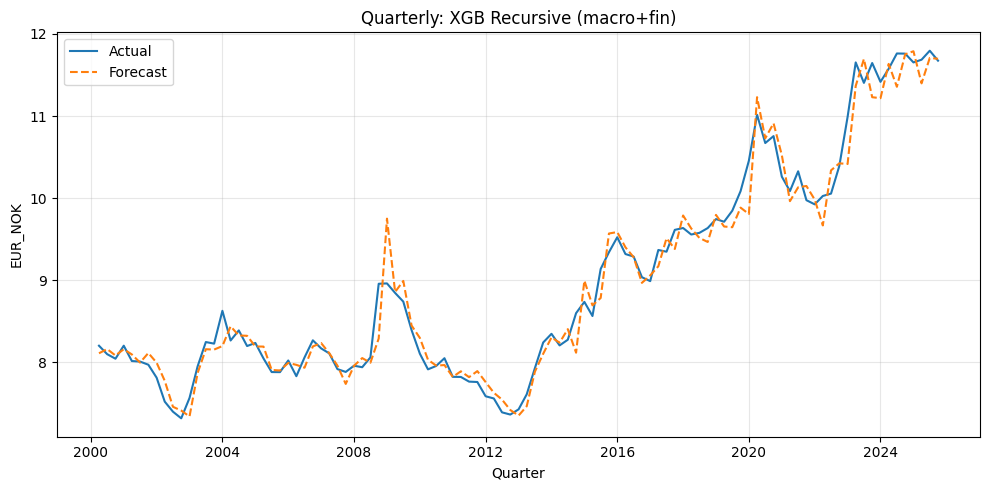

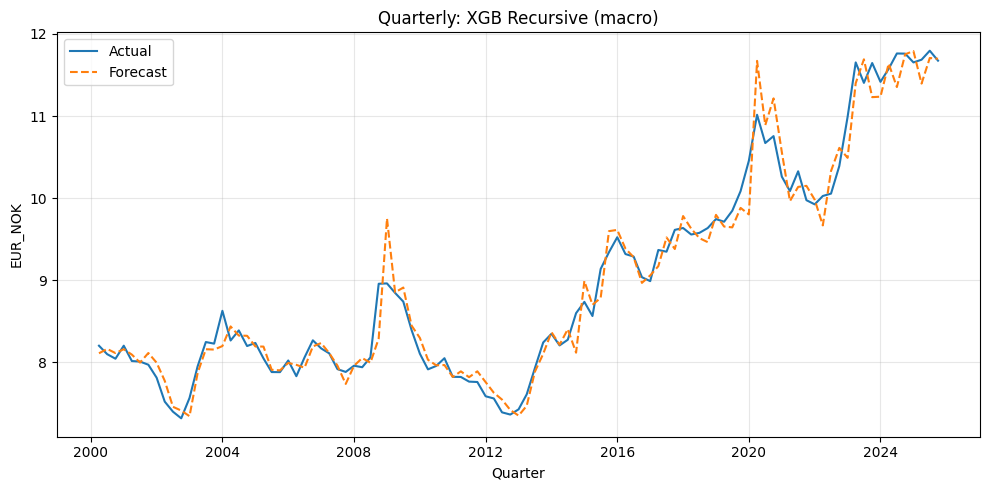


=== REGIME TABLES (QUARTERLY) ===

--- Full sample ---
                     Model  Obs     RMSE      MAE   DirAcc  DM_vs_RW  p_vs_RW  DM_n
 XGB Recursive (macro+fin)  103 0.209978 0.150358 0.735294 -1.229464 0.218898   102
     XGB Recursive (macro)  103 0.222638 0.159520 0.725490 -0.687019 0.492071   102
XGB Recursive (price-only)  103 0.227015 0.160659 0.725490 -0.471818 0.637057   102

--- Pre-GFC ---
                     Model  Obs     RMSE      MAE   DirAcc  DM_vs_RW  p_vs_RW  DM_n
XGB Recursive (price-only)   30 0.126916 0.097530 0.793103 -3.462568 0.000535    29
 XGB Recursive (macro+fin)   30 0.132667 0.100953 0.793103 -3.176098 0.001493    29
     XGB Recursive (macro)   30 0.132850 0.101928 0.758621 -3.158596 0.001585    29

--- GFC+ ---
                     Model  Obs     RMSE      MAE   DirAcc  DM_vs_RW  p_vs_RW  DM_n
     XGB Recursive (macro)   47 0.210636 0.142216 0.717391 -0.395248 0.692660    46
 XGB Recursive (macro+fin)   47 0.211600 0.144134 0.717391 -0.372319 0.70

In [ ]:
# ============================================================
# XGBoost (Quarterly) - A++: regimes + pairwise DM + NULL-centered block bootstrap DM vs RW
#
# - Data: variables_daily.csv (daily wide)
# - Target: EUR_NOK
# - Cut: last business day of previous quarter
# - Forecast: recursive daily from (cut+1) to (quarter end) -> quarterly mean over business days
# - Models:
#     1) XGB Recursive (price-only)
#     2) XGB Recursive (macro)        [past-only, publication lag in B-days]
#     3) XGB Recursive (macro+fin)    [past-only macro + fin as-of t-1]
#
# NOTE on Obs:
# - Includes the last (possibly partial) quarter if the dataset ends mid-quarter.
# ============================================================

# !pip -q install pandas numpy scikit-learn matplotlib requests certifi joblib xgboost

from __future__ import annotations
import io, math, time, warnings
from dataclasses import dataclass
from typing import Optional, Dict, Tuple, List

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests, certifi

from sklearn.metrics import mean_absolute_error
from joblib import Parallel, delayed
from xgboost import XGBRegressor

warnings.filterwarnings("ignore")


# -----------------------------
# CONFIG
# -----------------------------
@dataclass
class CFG:
    url_daily: str = (
        "https://raw.githubusercontent.com/bredeespelid/"
        "Data_MasterOppgave/refs/heads/main/Variables/All_Variables/variables_daily.csv"
    )
    target: str = "EUR_NOK"

    fin_cols: Tuple[str, ...] = ("Brent", "VIX", "StoxEurope", "SP500", "OSEBX", "OBX_Energy")
    macro_cols: Tuple[str, ...] = ("Q", "d_pi", "dI_t")

    macro_lag_bdays: int = 20  # publication lag in business days

    # Walk-forward rules
    q_freq: str = "Q-DEC"
    min_hist_days: int = 40
    max_lags: int = 20
    max_horizon_days: int = 200  # guard

    # XGB hyperparams (fixed cap)
    n_estimators: int = 150
    learning_rate: float = 0.04
    max_depth: int = 6
    min_child_weight: float = 7.0
    subsample: float = 0.6
    colsample_bytree: float = 1.0
    gamma: float = 0.05
    reg_alpha: float = 0.2
    reg_lambda: float = 0.5
    tree_method: str = "hist"
    objective: str = "reg:squarederror"
    eval_metric: str = "rmse"
    seed: int = 42

    # A++ bootstrap
    bootstrap_B: int = 800
    bootstrap_block: Optional[int] = None  # None -> auto ~ n^(1/3)

    # Download
    retries: int = 3
    timeout: int = 60

C = CFG()
print(f"Macro publication lag (B-days): {C.macro_lag_bdays}")


# -----------------------------
# DOWNLOAD + LOAD
# -----------------------------
def download_csv_text(url: str, retries: int, timeout: int) -> str:
    last_err = None
    for k in range(1, retries + 1):
        try:
            r = requests.get(url, timeout=timeout, verify=certifi.where())
            r.raise_for_status()
            return r.text
        except Exception as e:
            last_err = e
            if k < retries:
                time.sleep(1.2 * k)
    raise RuntimeError(f"Download failed: {last_err}")


def load_daily_panel(url: str) -> pd.DataFrame:
    text = download_csv_text(url, retries=C.retries, timeout=C.timeout)
    df = pd.read_csv(io.StringIO(text))
    if "Date" not in df.columns:
        raise KeyError("Daily panel must contain column 'Date'.")
    df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
    df = df.dropna(subset=["Date"]).sort_values("Date").set_index("Date")

    for col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

    if C.target not in df.columns:
        raise KeyError(f"Target {C.target} not found in daily panel.")
    return df


def to_business_and_daily_wide(df: pd.DataFrame) -> Tuple[pd.Series, pd.DataFrame]:
    keep = [C.target]
    keep += [c for c in (list(C.fin_cols) + list(C.macro_cols)) if c in df.columns]
    df0 = df[keep].copy()

    # Business-day truth base
    S_b = df0[C.target].asfreq("B").ffill().astype(float)
    S_b.name = C.target

    # Daily calendar (model inputs)
    full_idx = pd.date_range(df0.index.min(), df0.index.max(), freq="D")
    DF_d = df0.reindex(full_idx).ffill()
    DF_d.index.name = "DATE"
    return S_b, DF_d


def last_trading_day(S_b: pd.Series, start: pd.Timestamp, end: pd.Timestamp) -> Optional[pd.Timestamp]:
    sl = S_b.loc[start:end]
    return sl.index[-1] if not sl.empty else None


# -----------------------------
# PERIOD + TRUTH
# -----------------------------
def period_range_from_series(idx: pd.DatetimeIndex, freq: str) -> pd.PeriodIndex:
    first = pd.Period(idx.min(), freq=freq)
    last  = pd.Period(idx.max(), freq=freq)
    return pd.period_range(first, last, freq=freq)


def truth_mean_bdays(S_b: pd.Series, p: pd.Period) -> Optional[float]:
    idx = S_b.index[(S_b.index >= p.start_time) & (S_b.index <= p.end_time)]
    if idx.size == 0:
        return None
    return float(S_b.loc[idx].mean())


# -----------------------------
# FEATURES (daily one-step)
# -----------------------------
def _feature_order(variant: str, DF_cols: List[str]) -> List[str]:
    feats = [f"lag{k}" for k in range(1, C.max_lags + 1)]

    if variant in ("macro", "macro+fin"):
        for c in C.macro_cols:
            if c in DF_cols:
                feats.append(f"macro_{c}")

    if variant == "macro+fin":
        for c in C.fin_cols:
            if c in DF_cols:
                feats.append(f"fin_{c}")

    return feats


def macro_asof_series(DF_d: pd.DataFrame, col: str, lag_bdays: int) -> pd.Series:
    lagged_idx = DF_d.index - pd.tseries.offsets.BDay(lag_bdays)
    vals = DF_d[col].reindex(lagged_idx).to_numpy()
    return pd.Series(vals, index=DF_d.index, name=f"{col}_asofB{lag_bdays}")


def make_daily_supervised(DF_hist: pd.DataFrame, variant: str) -> Tuple[np.ndarray, np.ndarray, List[str]]:
    """
    Predict y_t using:
      - lag1..lagL of target
      - macro: macro_asof(t).shift(1) => known at (t-1 - lagB)
      - fin:  fin.shift(1)            => known at (t-1)
    """
    df = DF_hist.copy()
    y = df[C.target].astype(float)

    Xdf = pd.DataFrame(index=df.index)
    for k in range(1, C.max_lags + 1):
        Xdf[f"lag{k}"] = y.shift(k)

    if variant in ("macro", "macro+fin"):
        for c in C.macro_cols:
            if c in df.columns:
                m_asof = macro_asof_series(df, c, C.macro_lag_bdays)
                Xdf[f"macro_{c}"] = m_asof.shift(1)

    if variant == "macro+fin":
        for c in C.fin_cols:
            if c in df.columns:
                Xdf[f"fin_{c}"] = df[c].astype(float).shift(1)

    out = pd.concat([y.rename("y"), Xdf], axis=1).dropna()
    if len(out) < 20:
        raise ValueError("Too few observations after lagging.")

    feat_names = _feature_order(variant, DF_hist.columns.tolist())
    X = out[feat_names].to_numpy(dtype=float)
    y_target = out["y"].to_numpy(dtype=float)
    return X, y_target, feat_names


def fit_xgb_one_step(DF_hist: pd.DataFrame, variant: str) -> Tuple[XGBRegressor, List[str]]:
    X, y, feat_names = make_daily_supervised(DF_hist, variant)
    model = XGBRegressor(
        n_estimators=C.n_estimators,
        learning_rate=C.learning_rate,
        max_depth=C.max_depth,
        min_child_weight=C.min_child_weight,
        subsample=C.subsample,
        colsample_bytree=C.colsample_bytree,
        gamma=C.gamma,
        reg_alpha=C.reg_alpha,
        reg_lambda=C.reg_lambda,
        objective=C.objective,
        eval_metric=C.eval_metric,
        tree_method=C.tree_method,
        random_state=C.seed,
        n_jobs=1,
    )
    model.fit(X, y)
    return model, feat_names


def _frozen_exogs_at_cut(DF_hist: pd.DataFrame, variant: str, cut: pd.Timestamp) -> Tuple[Dict[str, float], Dict[str, float]]:
    """
    Freeze exogenous inputs as of forecast origin, consistent with training-time info constraints.
    - macro: last observed at (cut - BDay(lag)) (publication lag)
    - fin:  last observed at cut
    """
    macro_const: Dict[str, float] = {}
    fin_const: Dict[str, float] = {}

    if variant in ("macro", "macro+fin"):
        lag_cut = cut - pd.tseries.offsets.BDay(C.macro_lag_bdays)
        for c in C.macro_cols:
            if c in DF_hist.columns:
                s = DF_hist[c].loc[:lag_cut].dropna()
                macro_const[c] = float(s.iloc[-1]) if not s.empty else np.nan

    if variant == "macro+fin":
        for c in C.fin_cols:
            if c in DF_hist.columns:
                s = DF_hist[c].loc[:cut].dropna()
                fin_const[c] = float(s.iloc[-1]) if not s.empty else np.nan

    return macro_const, fin_const


def recursive_daily_forecast(
    model: XGBRegressor,
    DF_hist: pd.DataFrame,
    H: int,
    variant: str,
    cut: pd.Timestamp,
    feat_names: List[str],
) -> pd.Series:
    hist_y = DF_hist[C.target].astype(float).values.tolist()
    macro_const, fin_const = _frozen_exogs_at_cut(DF_hist, variant, cut)

    preds = []
    for _ in range(H):
        if len(hist_y) < C.max_lags:
            raise ValueError("Not enough history for lag features.")

        row = {}
        last_lags = hist_y[-C.max_lags:][::-1]  # [t-1,...,t-L]
        for k in range(1, C.max_lags + 1):
            row[f"lag{k}"] = float(last_lags[k - 1])

        if variant in ("macro", "macro+fin"):
            for c in C.macro_cols:
                if f"macro_{c}" in feat_names:
                    row[f"macro_{c}"] = float(macro_const.get(c, np.nan))

        if variant == "macro+fin":
            for c in C.fin_cols:
                if f"fin_{c}" in feat_names:
                    row[f"fin_{c}"] = float(fin_const.get(c, np.nan))

        x = np.array([row[n] for n in feat_names], dtype=float).reshape(1, -1)
        yhat = float(model.predict(x)[0])
        preds.append(yhat)
        hist_y.append(yhat)

    return pd.Series(preds, dtype=float)


# -----------------------------
# WALK-FORWARD QUARTERLY
# -----------------------------
def walk_forward_xgb_quarterly(S_b: pd.Series, DF_d: pd.DataFrame, variant: str, n_jobs_outer: int = -1) -> pd.DataFrame:
    quarters = period_range_from_series(S_b.index, freq=C.q_freq)

    def _one(q: pd.Period):
        prev_q = q - 1
        cut = last_trading_day(S_b, prev_q.start_time, prev_q.end_time)
        if cut is None:
            return (q, None, "no_cut_in_prev_quarter")

        DF_hist = DF_d.loc[:cut].copy()
        if len(DF_hist) < C.min_hist_days or len(DF_hist) <= C.max_lags:
            return (q, None, "hist_too_short")

        y_true = truth_mean_bdays(S_b, q)
        if y_true is None:
            return (q, None, "no_truth")

        # IMPORTANT: horizon from (cut+1) to quarter end
        f_start = cut + pd.Timedelta(days=1)
        f_end = q.end_time
        H = int((f_end.date() - f_start.date()).days + 1)
        if H <= 0 or H > C.max_horizon_days:
            return (q, None, f"horizon_invalid(H={H})")

        model, feat_names = fit_xgb_one_step(DF_hist, variant)
        pf = recursive_daily_forecast(model, DF_hist, H, variant, cut, feat_names)

        f_idx = pd.date_range(f_start, periods=H, freq="D")
        pred_daily = pd.Series(pf.values, index=f_idx)

        idx_b = S_b.index[(S_b.index >= q.start_time) & (S_b.index <= q.end_time)]
        pred_b = pred_daily.reindex(idx_b, method=None)
        if pred_b.isna().all():
            return (q, None, "no_overlap_pred_B_days")

        y_pred = float(pred_b.dropna().mean())
        return (q, {"period": q, "cut": cut, "y_true": y_true, "y_pred": y_pred}, None)

    res = Parallel(n_jobs=n_jobs_outer, backend="loky")(delayed(_one)(q) for q in quarters)

    rows, dropped = [], {}
    for q, row, reason in res:
        if row is not None:
            rows.append(row)
        else:
            dropped[str(q)] = reason or "unknown"

    df = pd.DataFrame(rows).set_index("period").sort_index()
    if dropped:
        print("\nDropped quarters and reasons:")
        for k, v in dropped.items():
            print(f"  {k}: {v}")
    return df


# -----------------------------
# METRICS + DM + BOOTSTRAP
# -----------------------------
def _normal_cdf(z: float) -> float:
    return 0.5 * (1.0 + math.erf(z / math.sqrt(2.0)))


def eval_metrics(df_eval: pd.DataFrame) -> Dict[str, float]:
    core = df_eval.dropna(subset=["y_true", "y_pred"]).copy()
    n = int(len(core))
    if n == 0:
        return dict(obs=0, rmse=np.nan, mae=np.nan, diracc=np.nan)

    err = core["y_true"] - core["y_pred"]
    rmse = float(np.sqrt(np.mean(err**2)))
    mae  = float(mean_absolute_error(core["y_true"], core["y_pred"]))

    core["y_prev"] = core["y_true"].shift(1)
    mask = core["y_prev"].notna()
    if mask.any():
        dir_true = np.sign(core.loc[mask, "y_true"] - core.loc[mask, "y_prev"])
        dir_pred = np.sign(core.loc[mask, "y_pred"] - core.loc[mask, "y_prev"])
        diracc = float((dir_true.values == dir_pred.values).mean())
    else:
        diracc = np.nan

    return dict(obs=n, rmse=rmse, mae=mae, diracc=diracc)


def _dm_from_d(d: np.ndarray) -> float:
    d = np.asarray(d, dtype=float)
    n = d.size
    if n < 10:
        return float("nan")
    sd = float(d.std(ddof=1))
    if not np.isfinite(sd) or sd <= 0:
        return float("nan")
    return float(d.mean() / (sd / math.sqrt(n)))


def dm_vs_rw(df_eval: pd.DataFrame) -> Tuple[float, float, int]:
    core = df_eval.dropna(subset=["y_true", "y_pred"]).copy()
    core["rw_pred"] = core["y_true"].shift(1)
    core = core.dropna(subset=["rw_pred"])
    if len(core) < 10:
        return float("nan"), float("nan"), int(len(core))

    e_m = core["y_true"].to_numpy() - core["y_pred"].to_numpy()
    e_r = core["y_true"].to_numpy() - core["rw_pred"].to_numpy()
    d = (e_m**2) - (e_r**2)

    dm = _dm_from_d(d)
    p  = float(2.0 * (1.0 - _normal_cdf(abs(dm)))) if np.isfinite(dm) else float("nan")
    return float(dm), float(p), int(len(d))


def dm_pairwise(df_a: pd.DataFrame, df_b: pd.DataFrame) -> Tuple[float, float, int]:
    df = pd.concat({"y": df_a["y_true"], "a": df_a["y_pred"], "b": df_b["y_pred"]}, axis=1).dropna()
    if len(df) < 10:
        return float("nan"), float("nan"), int(len(df))
    e_a = df["y"].to_numpy() - df["a"].to_numpy()
    e_b = df["y"].to_numpy() - df["b"].to_numpy()
    d = (e_a**2) - (e_b**2)
    dm = _dm_from_d(d)
    p  = float(2.0 * (1.0 - _normal_cdf(abs(dm)))) if np.isfinite(dm) else float("nan")
    return float(dm), float(p), int(len(d))


def block_bootstrap_dm_vs_rw_null_centered(
    df_eval: pd.DataFrame,
    B: int,
    block: Optional[int],
    seed: int = 42,
    one_sided: bool = True,  # "better than RW" => DM < 0
) -> Dict[str, float]:
    core = df_eval.dropna(subset=["y_true", "y_pred"]).copy()
    core["rw_pred"] = core["y_true"].shift(1)
    core = core.dropna(subset=["rw_pred"])

    n = int(len(core))
    if n < 30:
        return {"n": n, "dm_hat": np.nan, "p_boot": np.nan, "block": np.nan}

    e_m = core["y_true"].to_numpy() - core["y_pred"].to_numpy()
    e_r = core["y_true"].to_numpy() - core["rw_pred"].to_numpy()
    d = (e_m**2) - (e_r**2)

    dm_hat = _dm_from_d(d)
    if not np.isfinite(dm_hat):
        return {"n": n, "dm_hat": float("nan"), "p_boot": float("nan"), "block": float("nan")}

    d0 = d - d.mean()

    if block is None:
        b = int(round(n ** (1/3)))
        b = max(5, min(b, max(5, n // 2)))
    else:
        b = int(block)
        b = max(2, min(b, max(2, n // 2)))

    rng = np.random.default_rng(seed)
    starts = np.arange(0, n - b + 1)
    if starts.size == 0:
        return {"n": n, "dm_hat": float(dm_hat), "p_boot": np.nan, "block": float(b)}

    dm_boot = np.empty(B, dtype=float)
    dm_boot[:] = np.nan

    for i in range(B):
        idx = []
        while len(idx) < n:
            s = int(rng.choice(starts))
            idx.extend(range(s, s + b))
        idx = idx[:n]
        d_s = d0[np.array(idx, dtype=int)]
        dm_boot[i] = _dm_from_d(d_s)

    dm_boot = dm_boot[np.isfinite(dm_boot)]
    if dm_boot.size < 50:
        return {"n": n, "dm_hat": float(dm_hat), "p_boot": np.nan, "block": float(b)}

    if one_sided:
        if dm_hat < 0:
            p_boot = float(np.mean(dm_boot <= dm_hat))
        else:
            p_boot = float(np.mean(dm_boot >= dm_hat))
    else:
        p_boot = float(np.mean(np.abs(dm_boot) >= abs(dm_hat)))

    return {"n": n, "dm_hat": float(dm_hat), "p_boot": float(p_boot), "block": float(b)}


# -----------------------------
# REGIMES
# -----------------------------
@dataclass(frozen=True)
class Regime:
    name: str
    start: str
    end: str

REGIMES = [
    Regime("Full sample", "1900-01-01", "2100-01-01"),
    Regime("Pre-GFC", "2000-01-01", "2007-12-31"),
    Regime("GFC+", "2008-01-01", "2019-12-31"),
    Regime("COVID+", "2020-01-01", "2021-12-31"),
    Regime("Energy+FX shock", "2022-01-01", "2100-01-01"),
]

def filter_eval_by_regime(df_eval: pd.DataFrame, reg: Regime) -> pd.DataFrame:
    ts = df_eval.index.to_timestamp(how="end")
    mask = (ts >= pd.Timestamp(reg.start)) & (ts <= pd.Timestamp(reg.end))
    return df_eval.loc[mask]


def summary_table(models: Dict[str, pd.DataFrame]) -> pd.DataFrame:
    rows = []
    for name, df_eval in models.items():
        st = eval_metrics(df_eval)
        dm, p, n_dm = dm_vs_rw(df_eval)
        rows.append({
            "Model": name,
            "Obs": st["obs"],
            "RMSE": st["rmse"],
            "MAE": st["mae"],
            "DirAcc": st["diracc"],
            "DM_vs_RW": dm,
            "p_vs_RW": p,
            "DM_n": n_dm,
        })
    return pd.DataFrame(rows).sort_values("RMSE")


def plot_actual_vs_pred(df_eval: pd.DataFrame, title: str):
    core = df_eval.dropna(subset=["y_true", "y_pred"]).copy()
    if core.empty:
        return
    x = core.index.to_timestamp()
    plt.figure(figsize=(10, 5))
    plt.plot(x, core["y_true"], label="Actual")
    plt.plot(x, core["y_pred"], "--", label="Forecast")
    plt.title(title)
    plt.xlabel("Quarter")
    plt.ylabel(C.target)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()


# -----------------------------
# RUN QUARTERLY
# -----------------------------
df_daily = load_daily_panel(C.url_daily)
S_b, DF_d = to_business_and_daily_wide(df_daily)

print(f"Daily panel: {df_daily.index.min().date()} -> {df_daily.index.max().date()} | rows={len(df_daily)}")
print(f"S_b: {S_b.index.min().date()} -> {S_b.index.max().date()} | n={len(S_b)}")
print(f"DF_d: {DF_d.index.min().date()} -> {DF_d.index.max().date()} | rows={len(DF_d)}")

models = {
    "XGB Recursive (price-only)": walk_forward_xgb_quarterly(S_b, DF_d[[C.target]].copy(), variant="price-only", n_jobs_outer=-1),
    "XGB Recursive (macro)":      walk_forward_xgb_quarterly(S_b, DF_d.copy(), variant="macro", n_jobs_outer=-1),
    "XGB Recursive (macro+fin)":  walk_forward_xgb_quarterly(S_b, DF_d.copy(), variant="macro+fin", n_jobs_outer=-1),
}

tbl = summary_table(models)
print("\n=== QUARTERLY (XGB only) ===")
print(tbl.to_string(index=False))

# Plot top-2
top2 = tbl["Model"].head(2).tolist()
for m in top2:
    plot_actual_vs_pred(models[m], f"Quarterly: {m}")

# Regime tables
print("\n=== REGIME TABLES (QUARTERLY) ===")
for reg in REGIMES:
    sub = {k: filter_eval_by_regime(v, reg) for k, v in models.items()}
    t = summary_table(sub)
    print(f"\n--- {reg.name} ---")
    print(t.to_string(index=False))

# Pairwise DM for top-2
if len(top2) >= 2:
    dm, p, n = dm_pairwise(models[top2[0]], models[top2[1]])
    print("\n=== Pairwise DM (MSE): Quarterly top-2 ===")
    print(f"{top2[0]} vs {top2[1]}")
    print(f"DM-stat: {dm:.4f} | p-value: {p:.4f} | N={n}")

# Null-centered block bootstrap DM vs RW (top-2)
print("\n=== Null-centered block-bootstrap DM vs RW (QUARTERLY, top-2, one-sided) ===")
for m in top2:
    res = block_bootstrap_dm_vs_rw_null_centered(
        models[m],
        B=C.bootstrap_B,
        block=C.bootstrap_block,
        seed=42,
        one_sided=True
    )
    print(f"{m}: DM_hat={res['dm_hat']:.4f} | p_boot={res['p_boot']:.4f} | DM_n={res['n']} | block={int(res['block'])}")


## LOFO

In [11]:
# ============================================================
# A++ Robustness pack for FIXED (selected) covariate sets
# - EUR/NOK, monthly + quarterly
# - Models:
#   (1) Chronos2 price-only vs Chronos2 selected covariates
#   (2) XGB (expanding walk-forward) price-only vs XGB selected covariates
# - Outputs (per horizon & family):
#   - Main summary table
#   - Regime tables
#   - Pairwise DM (top-2)
#   - Null-centered block bootstrap vs RW (one-sided), top-2
# ============================================================

!pip -q install pandas numpy scikit-learn matplotlib requests certifi torch xgboost
!pip -q install chronos-forecasting boto3 botocore

from __future__ import annotations
import io, math, time, warnings
from dataclasses import dataclass
from typing import Optional, Dict, Tuple, List

import numpy as np
import pandas as pd
import requests, certifi

import torch
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor

from chronos import BaseChronosPipeline

warnings.filterwarnings("ignore")


# -----------------------------
# CONFIG
# -----------------------------
@dataclass
class CFG:
    url_daily: str = (
        "https://raw.githubusercontent.com/bredeespelid/"
        "Data_MasterOppgave/refs/heads/main/Variables/All_Variables/variables_daily.csv"
    )
    target: str = "EUR_NOK"

    # publication lag (business days) for macro variables
    macro_cols: Tuple[str, ...] = ("Q", "d_pi", "dI_t")
    macro_lag_bdays: int = 20

    # Chronos settings
    chronos_model: str = "amazon/chronos-2"
    chronos_max_context: int = 2048
    chronos_fp16_on_cuda: bool = True
    min_hist_days: int = 40
    max_horizon_days: int = 128  # guard

    # XGB walk-forward settings (period-level)
    min_train_periods_monthly: int = 60
    min_train_periods_quarterly: int = 30

    # bootstrap
    bootstrap_B: int = 800
    block_monthly: int = 7
    block_quarterly: int = 5

    # download robustness
    retries: int = 3
    timeout: int = 60

C = CFG()
USE_CUDA = bool(torch.cuda.is_available())
print(f"CUDA available: {USE_CUDA} | device={'cuda' if USE_CUDA else 'cpu'} | macro_lag_bdays={C.macro_lag_bdays}")


# -----------------------------
# SELECTED COVARIATE SETS (EXACTLY as in your Results text)
# -----------------------------
COVSETS = {
    # XGB (selected)
    "XGB Monthly (selected)": ["Brent", "OSEBX", "StoxEurope", "d_pi", "Q", "dI_t"],
    "XGB Quarterly (selected)": ["VIX", "StoxEurope", "SP500", "OSEBX", "OBX_Energy", "Q", "d_pi", "dI_t"],

    # Chronos2 (selected)
    "Chronos2 Monthly (selected)": ["VIX", "SP500", "StoxEurope", "OSEBX", "OBX_EN", "dI_t"],
    "Chronos2 Quarterly (selected)": ["VIX", "SP500", "Q"],
}

# Column aliasing to tolerate naming differences in the CSV
ALIASES = {
    "OBX_EN": ["OBX_EN", "OBX_Energy", "OBX_EN_t", "OBXEnergy", "OBX_ENERGY", "OBX_Energy_Index"],
    "OBX_Energy": ["OBX_Energy", "OBX_EN", "OBXEnergy", "OBX_ENERGY", "OBX_Energy_Index"],
    "dI_t": ["dI_t", "dI", "dI_t_", "dI_t_lag", "dI_t_l1"],
    "d_pi": ["d_pi", "dpi", "dπ", "d_pi_", "d_pi_lag"],
    "Q": ["Q", "q", "q_t", "qt", "q"],
}

def resolve_cov_list(covs: List[str], DF_d: pd.DataFrame) -> List[str]:
    out = []
    for c in covs:
        if c in DF_d.columns:
            out.append(c); continue
        if c in ALIASES:
            found = next((a for a in ALIASES[c] if a in DF_d.columns), None)
            if found is not None:
                out.append(found); continue
        # silently drop if missing
    # unique, preserve order
    seen, out2 = set(), []
    for c in out:
        if c not in seen:
            out2.append(c); seen.add(c)
    return out2


# -----------------------------
# DATA LOADING
# -----------------------------
def download_csv_text(url: str, retries: int, timeout: int) -> str:
    last_err = None
    for k in range(1, retries + 1):
        try:
            r = requests.get(url, timeout=timeout, verify=certifi.where())
            r.raise_for_status()
            return r.text
        except Exception as e:
            last_err = e
            if k < retries:
                time.sleep(1.2 * k)
    raise RuntimeError(f"Download failed: {last_err}")

def load_daily_panel(url: str) -> pd.DataFrame:
    text = download_csv_text(url, retries=C.retries, timeout=C.timeout)
    df = pd.read_csv(io.StringIO(text))
    if "Date" not in df.columns:
        raise KeyError("Daily panel must contain column 'Date'.")
    df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
    df = df.dropna(subset=["Date"]).sort_values("Date").set_index("Date")
    for col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")
    if C.target not in df.columns:
        raise KeyError(f"Target {C.target} not found in daily panel.")
    return df

def to_business_and_daily(df: pd.DataFrame) -> Tuple[pd.Series, pd.Series, pd.DataFrame]:
    # keep all columns; downstream selects needed ones
    df0 = df.copy()
    S_b = df0[C.target].asfreq("B").ffill().astype(float)
    S_b.name = C.target
    full_idx = pd.date_range(df0.index.min(), df0.index.max(), freq="D")
    DF_d = df0.reindex(full_idx).ffill()
    DF_d.index.name = "DATE"
    S_d = DF_d[C.target].astype(float).copy()
    S_d.name = C.target
    return S_b, S_d, DF_d


# -----------------------------
# PERIOD HELPERS
# -----------------------------
def last_trading_day(S_b: pd.Series, start: pd.Timestamp, end: pd.Timestamp) -> Optional[pd.Timestamp]:
    sl = S_b.loc[start:end]
    return sl.index[-1] if not sl.empty else None

def period_range_from_series(idx: pd.DatetimeIndex, freq: str) -> pd.PeriodIndex:
    first = pd.Period(idx.min(), freq=freq)
    last  = pd.Period(idx.max(), freq=freq)
    return pd.period_range(first, last, freq=freq)

def truth_mean_bdays(S_b: pd.Series, p: pd.Period) -> Optional[float]:
    idx = S_b.index[(S_b.index >= p.start_time) & (S_b.index <= p.end_time)]
    if idx.size == 0:
        return None
    return float(S_b.loc[idx].mean())

def _make_hist_wide_with_macro_lag(DF_d: pd.DataFrame, cut: pd.Timestamp) -> pd.DataFrame:
    hist = DF_d.loc[:cut].copy()
    lag_cut = cut - pd.tseries.offsets.BDay(C.macro_lag_bdays)
    for c in C.macro_cols:
        # apply lag only if the column exists under any alias
        if c in hist.columns:
            hist[c] = DF_d[c].loc[:lag_cut].reindex(hist.index).ffill()
        elif c in ALIASES:
            found = next((a for a in ALIASES[c] if a in hist.columns), None)
            if found is not None:
                hist[found] = DF_d[found].loc[:lag_cut].reindex(hist.index).ffill()
    return hist


# -----------------------------
# DM + BOOTSTRAP
# -----------------------------
def _normal_cdf(z: float) -> float:
    return 0.5 * (1.0 + math.erf(z / math.sqrt(2.0)))

def dm_test(y_true: pd.Series, y_model: pd.Series, y_rw: pd.Series, h: int = 1, loss: str = "mse") -> Tuple[float, float, int]:
    df = pd.concat({"y": y_true, "m": y_model, "rw": y_rw}, axis=1).dropna()
    if df.empty or len(df) < 10:
        return float("nan"), float("nan"), int(len(df))

    e_m = df["y"] - df["m"]
    e_r = df["y"] - df["rw"]
    d = (np.abs(e_m) - np.abs(e_r)) if loss.lower() == "mae" else ((e_m**2) - (e_r**2))

    N = int(len(d))
    d_mean = float(d.mean())
    gamma0 = float(np.var(d, ddof=1))
    var_bar = gamma0 / N
    if not np.isfinite(var_bar) or var_bar <= 0:
        return float("nan"), float("nan"), N

    dm_stat = d_mean / math.sqrt(var_bar)
    p_val = 2.0 * (1.0 - _normal_cdf(abs(dm_stat)))
    return float(dm_stat), float(p_val), N

def dm_stat_only(y_true: pd.Series, y_model: pd.Series, y_rw: pd.Series) -> float:
    df = pd.concat({"y": y_true, "m": y_model, "rw": y_rw}, axis=1).dropna()
    if df.empty or len(df) < 10:
        return float("nan")
    e_m = df["y"] - df["m"]
    e_r = df["y"] - df["rw"]
    d = (e_m**2) - (e_r**2)
    sd = float(d.std(ddof=1))
    return float(d.mean() / (sd / math.sqrt(len(d)))) if sd > 0 else float("nan")

def block_bootstrap_dm_vs_rw(df_eval: pd.DataFrame, B: int, block: int, seed: int = 42) -> Dict[str, float]:
    core = df_eval.dropna(subset=["y_true", "y_pred"]).copy()
    core["rw_pred"] = core["y_true"].shift(1)
    core = core.dropna(subset=["rw_pred"])
    n = len(core)
    if n < 30:
        return {"n": n, "dm_hat": np.nan, "p_boot": np.nan}

    dm_hat, _, _ = dm_test(core["y_true"], core["y_pred"], core["rw_pred"], h=1, loss="mse")

    rng = np.random.default_rng(seed)
    starts = np.arange(0, n - block + 1)
    if starts.size == 0:
        return {"n": n, "dm_hat": float(dm_hat), "p_boot": np.nan}

    dm_boot = []
    for _ in range(B):
        idx = []
        while len(idx) < n:
            s = int(rng.choice(starts))
            idx.extend(range(s, s + block))
        idx = idx[:n]
        samp = core.iloc[idx]
        dm_b = dm_stat_only(samp["y_true"], samp["y_pred"], samp["rw_pred"])
        if np.isfinite(dm_b):
            dm_boot.append(dm_b)

    dm_boot = np.asarray(dm_boot, dtype=float)
    if dm_boot.size < 50:
        return {"n": n, "dm_hat": float(dm_hat), "p_boot": np.nan}

    # one-sided: DM < 0 is "model better than RW"
    p_boot = float(np.mean(dm_boot >= dm_hat))
    return {"n": n, "dm_hat": float(dm_hat), "p_boot": p_boot}

def dm_pairwise(df_a: pd.DataFrame, df_b: pd.DataFrame) -> Tuple[float, float, int]:
    df = pd.concat({"y": df_a["y_true"], "a": df_a["y_pred"], "b": df_b["y_pred"]}, axis=1).dropna()
    if df.empty or len(df) < 10:
        return float("nan"), float("nan"), int(len(df))
    e_a = df["y"] - df["a"]
    e_b = df["y"] - df["b"]
    d = (e_a**2) - (e_b**2)
    N = int(len(d))
    sd = float(d.std(ddof=1))
    dm_stat = float(d.mean() / (sd / math.sqrt(N))) if sd > 0 else float("nan")
    p_val = 2.0 * (1.0 - _normal_cdf(abs(dm_stat))) if np.isfinite(dm_stat) else float("nan")
    return dm_stat, p_val, N


# -----------------------------
# METRICS TABLE
# -----------------------------
def eval_metrics_forecast(df_eval: pd.DataFrame) -> Dict[str, float]:
    core = df_eval.dropna(subset=["y_true", "y_pred"]).copy()
    n = int(len(core))
    if n == 0:
        return dict(obs=0, rmse=np.nan, mae=np.nan, diracc=np.nan)

    err = core["y_true"] - core["y_pred"]
    rmse = float(np.sqrt(np.mean(err**2)))
    mae  = float(mean_absolute_error(core["y_true"], core["y_pred"]))

    core["y_prev"] = core["y_true"].shift(1)
    mask = core["y_prev"].notna()
    diracc = float((np.sign(core.loc[mask, "y_true"] - core.loc[mask, "y_prev"]).values
                    == np.sign(core.loc[mask, "y_pred"] - core.loc[mask, "y_prev"]).values).mean()) if mask.any() else np.nan
    return dict(obs=n, rmse=rmse, mae=mae, diracc=diracc)

def add_rw_and_dm(df_eval: pd.DataFrame) -> Tuple[float, float, int]:
    df = df_eval.dropna(subset=["y_true", "y_pred"]).copy()
    df["rw_pred"] = df["y_true"].shift(1)
    df = df.dropna(subset=["rw_pred"])
    dm, p, n_dm = dm_test(df["y_true"], df["y_pred"], df["rw_pred"], h=1, loss="mse")
    return dm, p, n_dm

def summary_table(models: Dict[str, pd.DataFrame]) -> pd.DataFrame:
    rows = []
    for name, df_eval in models.items():
        st = eval_metrics_forecast(df_eval)
        dm, p, n_dm = add_rw_and_dm(df_eval)
        rows.append({
            "Model": name,
            "Obs": st["obs"],
            "RMSE": st["rmse"],
            "MAE": st["mae"],
            "DirAcc": st["diracc"],
            "DM_vs_RW": dm,
            "p_vs_RW": p,
            "DM_n": n_dm
        })
    return pd.DataFrame(rows).sort_values("RMSE")


# -----------------------------
# REGIMES (same as your setup)
# -----------------------------
@dataclass(frozen=True)
class Regime:
    name: str
    start: str
    end: str

REGIMES = [
    Regime("Full sample", "1900-01-01", "2100-01-01"),
    Regime("Pre-GFC", "2000-01-01", "2007-12-31"),
    Regime("GFC+", "2008-01-01", "2019-12-31"),
    Regime("COVID+", "2020-01-01", "2021-12-31"),
    Regime("Energy+FX shock", "2022-01-01", "2100-01-01"),
]

def _period_to_ts_end(idx: pd.PeriodIndex) -> pd.DatetimeIndex:
    return idx.to_timestamp(how="end")

def filter_eval_by_regime(df_eval: pd.DataFrame, reg: Regime) -> pd.DataFrame:
    ts = _period_to_ts_end(df_eval.index)
    mask = (ts >= pd.Timestamp(reg.start)) & (ts <= pd.Timestamp(reg.end))
    return df_eval.loc[mask]

def summary_table_by_regime(models: Dict[str, pd.DataFrame], regimes: List[Regime]) -> Dict[str, pd.DataFrame]:
    out = {}
    for reg in regimes:
        sub = {k: filter_eval_by_regime(v, reg) for k, v in models.items()}
        out[reg.name] = summary_table(sub)
    return out


# -----------------------------
# CHRONOS PIPELINE + FORECASTERS (pastcov + price-only)
# -----------------------------
def build_chronos_pipeline() -> BaseChronosPipeline:
    if USE_CUDA and C.chronos_fp16_on_cuda:
        return BaseChronosPipeline.from_pretrained(C.chronos_model, device_map="cuda", dtype=torch.float16)
    if USE_CUDA:
        return BaseChronosPipeline.from_pretrained(C.chronos_model, device_map="cuda", dtype=torch.float32)
    return BaseChronosPipeline.from_pretrained(C.chronos_model, device_map="cpu", dtype=torch.float32)

def make_pastcov_context(hist_wide: pd.DataFrame, cov_cols: List[str]) -> pd.DataFrame:
    ctx = pd.DataFrame({
        "timestamp": hist_wide.index,
        "item_id": C.target,
        "target": hist_wide[C.target].astype(float).values,
    })
    for c in cov_cols:
        ctx[c] = hist_wide[c].astype(float).values
    return ctx.sort_values("timestamp")

def chronos_forecast_pastcov(pipe: BaseChronosPipeline, context_df: pd.DataFrame, H: int) -> pd.DataFrame:
    with torch.inference_mode():
        pred = pipe.predict_df(
            context_df,
            prediction_length=H,
            quantile_levels=[0.5],
            id_column="item_id",
            timestamp_column="timestamp",
            target="target",
            predict_batches_jointly=False,
        )
    pred = pred.sort_values("timestamp")
    if "0.5" in pred.columns:
        return pred.rename(columns={"0.5": "y_pred"})[["item_id", "timestamp", "y_pred"]].copy()
    if "predictions" in pred.columns:
        return pred.rename(columns={"predictions": "y_pred"})[["item_id", "timestamp", "y_pred"]].copy()
    raise RuntimeError(f"Unsupported Chronos output columns: {list(pred.columns)}")

def chronos_forecast_price_only(pipe: BaseChronosPipeline, ctx_values: np.ndarray, H: int) -> np.ndarray:
    ctx = np.asarray(ctx_values, dtype=float).ravel()[-C.chronos_max_context:]
    ts = pd.date_range("2000-01-01", periods=len(ctx), freq="D")
    df = pd.DataFrame({"item_id": "series_1", "timestamp": ts, "target": ctx})
    with torch.inference_mode():
        pred = pipe.predict_df(df, prediction_length=H, quantile_levels=[0.5])
    pred = pred.sort_values("timestamp")
    if "0.5" in pred.columns:
        return pred["0.5"].to_numpy(dtype=float)[:H]
    if "predictions" in pred.columns:
        return pred["predictions"].to_numpy(dtype=float)[:H]
    raise RuntimeError(f"Unsupported Chronos output columns: {list(pred.columns)}")

def walk_forward_chronos_period_price_only(S_b: pd.Series, S_d: pd.Series, pipe: BaseChronosPipeline, freq: str) -> pd.DataFrame:
    periods = period_range_from_series(S_b.index, freq=freq)
    rows, dropped = [], {}
    for P in periods:
        prevP = P - 1
        cut = last_trading_day(S_b, prevP.start_time, prevP.end_time)
        if cut is None:
            dropped[str(P)] = "no_cut"; continue

        hist = S_d.loc[:cut].dropna()
        if len(hist) < C.min_hist_days:
            dropped[str(P)] = "short_hist"; continue

        y_true = truth_mean_bdays(S_b, P)
        if y_true is None:
            dropped[str(P)] = "no_truth"; continue

        H = int((P.end_time.date() - P.start_time.date()).days + 1)
        if H <= 0 or H > C.max_horizon_days:
            dropped[str(P)] = f"bad_horizon(H={H})"; continue

        pf = chronos_forecast_price_only(pipe, hist.values, H)
        f_idx = pd.date_range(cut + pd.Timedelta(days=1), periods=H, freq="D")
        pred_daily = pd.Series(pf, index=f_idx)

        idx_b = S_b.index[(S_b.index >= P.start_time) & (S_b.index <= P.end_time)]
        pred_b = pred_daily.reindex(idx_b, method=None)
        if pred_b.isna().all():
            dropped[str(P)] = "no_overlap_B"; continue

        y_pred = float(pred_b.dropna().mean())
        rows.append({"period": P, "cut": cut, "y_true": y_true, "y_pred": y_pred})

    df = pd.DataFrame(rows).set_index("period").sort_index()
    return df

def walk_forward_chronos_period_pastcov(S_b: pd.Series, DF_d: pd.DataFrame, pipe: BaseChronosPipeline, freq: str, cov_cols: List[str]) -> pd.DataFrame:
    periods = period_range_from_series(S_b.index, freq=freq)
    rows, dropped = [], {}
    for P in periods:
        prevP = P - 1
        cut = last_trading_day(S_b, prevP.start_time, prevP.end_time)
        if cut is None:
            dropped[str(P)] = "no_cut"; continue

        hist_wide = _make_hist_wide_with_macro_lag(DF_d, cut).dropna(subset=[C.target])
        if len(hist_wide) < C.min_hist_days:
            dropped[str(P)] = "short_hist"; continue

        y_true = truth_mean_bdays(S_b, P)
        if y_true is None:
            dropped[str(P)] = "no_truth"; continue

        H = int((P.end_time.date() - P.start_time.date()).days + 1)
        if H <= 0 or H > C.max_horizon_days:
            dropped[str(P)] = f"bad_horizon(H={H})"; continue

        context_df = make_pastcov_context(hist_wide, cov_cols)
        pred_df = chronos_forecast_pastcov(pipe, context_df, H)

        f_idx = pd.date_range(cut + pd.Timedelta(days=1), periods=H, freq="D")
        pred_daily = pd.Series(index=f_idx, dtype=float)

        tmp = pred_df.set_index("timestamp")["y_pred"]
        common = tmp.index.intersection(pred_daily.index)
        pred_daily.loc[common] = tmp.loc[common]
        pred_daily = pred_daily.ffill()

        idx_b = S_b.index[(S_b.index >= P.start_time) & (S_b.index <= P.end_time)]
        pred_b = pred_daily.reindex(idx_b, method=None)
        if pred_b.isna().all():
            dropped[str(P)] = "no_overlap_B"; continue

        y_pred = float(pred_b.dropna().mean())
        rows.append({"period": P, "cut": cut, "y_true": y_true, "y_pred": y_pred})

    df = pd.DataFrame(rows).set_index("period").sort_index()
    return df


# -----------------------------
# XGB WALK-FORWARD (period-level mean target)
# -----------------------------
def _value_at_or_before(DF_d: pd.DataFrame, col: str, t: pd.Timestamp) -> float:
    s = DF_d[col].loc[:t]
    if s.empty:
        return np.nan
    return float(s.iloc[-1])

def make_period_dataset(S_b: pd.Series, DF_d: pd.DataFrame, freq: str, cov_cols: List[str]) -> pd.DataFrame:
    periods = period_range_from_series(S_b.index, freq=freq)
    rows = []
    for P in periods:
        prevP = P - 1
        cut = last_trading_day(S_b, prevP.start_time, prevP.end_time)
        if cut is None:
            continue

        y_true = truth_mean_bdays(S_b, P)
        if y_true is None:
            continue

        # Features at cut: always include lagged EUR/NOK level (price-only baseline)
        x = {}
        x["lag_y"] = _value_at_or_before(DF_d, C.target, cut)

        # covariates at cut; macro with publication lag
        lag_cut = cut - pd.tseries.offsets.BDay(C.macro_lag_bdays)
        for c in cov_cols:
            is_macro = (c in DF_d.columns) and (c in list(C.macro_cols) or c in resolve_cov_list(list(C.macro_cols), DF_d))
            t_use = lag_cut if is_macro else cut
            x[c] = _value_at_or_before(DF_d, c, t_use)

        rows.append({"period": P, "cut": cut, "y_true": float(y_true), **x})

    df = pd.DataFrame(rows).set_index("period").sort_index()
    return df

def walk_forward_xgb(S_b: pd.Series, DF_d: pd.DataFrame, freq: str, cov_cols: List[str], min_train_periods: int, seed: int = 42) -> pd.DataFrame:
    ds = make_period_dataset(S_b, DF_d, freq=freq, cov_cols=cov_cols)

    # drop rows with missing target or lag_y
    ds = ds.dropna(subset=["y_true", "lag_y"]).copy()
    feature_cols = ["lag_y"] + [c for c in cov_cols if c in ds.columns]

    rows = []
    for i, P in enumerate(ds.index):
        train = ds.iloc[:i]
        test  = ds.loc[[P]]

        if len(train) < min_train_periods:
            continue

        Xtr = train[feature_cols].astype(float)
        ytr = train["y_true"].astype(float)
        Xte = test[feature_cols].astype(float)

        # basic, stable XGB config for forecasting (keep it simple & reproducible)
        model = XGBRegressor(
            n_estimators=600,
            max_depth=3,
            learning_rate=0.03,
            subsample=0.8,
            colsample_bytree=0.9,
            reg_lambda=1.0,
            random_state=seed,
            objective="reg:squarederror",
            n_jobs=-1,
        )

        model.fit(Xtr, ytr)
        y_pred = float(model.predict(Xte)[0])

        rows.append({"period": P, "y_true": float(test["y_true"].iloc[0]), "y_pred": y_pred})

    df_eval = pd.DataFrame(rows).set_index("period").sort_index()
    return df_eval


# -----------------------------
# ROBUST PRINTING (same style as your earlier outputs)
# -----------------------------
def run_block(title: str, models: Dict[str, pd.DataFrame], block: int):
    print(f"\n=== {title} ===")
    tbl = summary_table(models)
    print(tbl.to_string(index=False))

    # regime tables (metrics + DM/p)
    print(f"\n=== REGIME TABLES ({title}) ===")
    reg_tbls = summary_table_by_regime(models, REGIMES)
    for reg_name, t in reg_tbls.items():
        print(f"\n--- {reg_name} ---")
        print(t.to_string(index=False))

    # pairwise DM top-2 (RMSE)
    top2 = tbl["Model"].head(2).tolist()
    if len(top2) >= 2:
        dm, p, n = dm_pairwise(models[top2[0]], models[top2[1]])
        print(f"\n=== Pairwise DM (MSE): {title} top-2 ===")
        print(f"{top2[0]} vs {top2[1]}")
        print(f"DM-stat: {dm:.4f} | p-value: {p:.4f} | N={n}")

    # null-centered block bootstrap vs RW for top-2
    print(f"\n=== Null-centered block-bootstrap DM vs RW ({title}, top-2, one-sided) ===")
    for m in top2:
        res = block_bootstrap_dm_vs_rw(models[m], B=C.bootstrap_B, block=block, seed=42)
        # DM_hat is DM vs RW (same sign convention as dm_test)
        print(f"{m}: DM_hat={res['dm_hat']:.4f} | p_boot={res['p_boot']:.4f} | DM_n={res['n']} | block={block}")


# ============================================================
# RUN EVERYTHING (selected sets + price-only baselines)
# ============================================================
df_daily = load_daily_panel(C.url_daily)
S_b, S_d, DF_d = to_business_and_daily(df_daily)

print(f"Daily panel: {df_daily.index.min().date()} → {df_daily.index.max().date()} | rows={len(df_daily)}")
print(f"S_b: {S_b.index.min().date()} → {S_b.index.max().date()} | n={len(S_b)}")
print(f"DF_d: {DF_d.index.min().date()} → {DF_d.index.max().date()} | rows={len(DF_d)}")

# Build Chronos pipeline once
pipe = build_chronos_pipeline()

# Resolve covariates against DF_d
chronos_m_cov = resolve_cov_list(COVSETS["Chronos2 Monthly (selected)"], DF_d)
chronos_q_cov = resolve_cov_list(COVSETS["Chronos2 Quarterly (selected)"], DF_d)

xgb_m_cov = resolve_cov_list(COVSETS["XGB Monthly (selected)"], DF_d)
xgb_q_cov = resolve_cov_list(COVSETS["XGB Quarterly (selected)"], DF_d)

print("\nResolved covariates:")
print("  Chronos2 Monthly:", chronos_m_cov)
print("  Chronos2 Quarterly:", chronos_q_cov)
print("  XGB Monthly:", xgb_m_cov)
print("  XGB Quarterly:", xgb_q_cov)

# -----------------------------
# CHRONOS2: MONTHLY + QUARTERLY (selected vs price-only)
# -----------------------------
chronos_models_monthly = {
    "Chronos2 (selected covariates)": walk_forward_chronos_period_pastcov(S_b, DF_d, pipe, freq="M", cov_cols=chronos_m_cov),
    "Chronos2 (price-only)":          walk_forward_chronos_period_price_only(S_b, S_d, pipe, freq="M"),
}
run_block("MONTHLY (Chronos2 selected vs price-only)", chronos_models_monthly, block=C.block_monthly)

chronos_models_quarterly = {
    "Chronos2 (selected covariates)": walk_forward_chronos_period_pastcov(S_b, DF_d, pipe, freq="Q-DEC", cov_cols=chronos_q_cov),
    "Chronos2 (price-only)":          walk_forward_chronos_period_price_only(S_b, S_d, pipe, freq="Q-DEC"),
}
run_block("QUARTERLY (Chronos2 selected vs price-only)", chronos_models_quarterly, block=C.block_quarterly)

# -----------------------------
# XGB: MONTHLY + QUARTERLY (selected vs price-only)
# -----------------------------
xgb_models_monthly = {
    "XGB (selected covariates)": walk_forward_xgb(S_b, DF_d, freq="M", cov_cols=xgb_m_cov, min_train_periods=C.min_train_periods_monthly, seed=42),
    "XGB (price-only)":          walk_forward_xgb(S_b, DF_d, freq="M", cov_cols=[],     min_train_periods=C.min_train_periods_monthly, seed=42),
}
run_block("MONTHLY (XGB selected vs price-only)", xgb_models_monthly, block=C.block_monthly)

xgb_models_quarterly = {
    "XGB (selected covariates)": walk_forward_xgb(S_b, DF_d, freq="Q-DEC", cov_cols=xgb_q_cov, min_train_periods=C.min_train_periods_quarterly, seed=42),
    "XGB (price-only)":          walk_forward_xgb(S_b, DF_d, freq="Q-DEC", cov_cols=[],      min_train_periods=C.min_train_periods_quarterly, seed=42),
}
run_block("QUARTERLY (XGB selected vs price-only)", xgb_models_quarterly, block=C.block_quarterly)


CUDA available: True | device=cuda | macro_lag_bdays=20
Daily panel: 2000-01-31 → 2025-11-10 | rows=9416
S_b: 2000-01-31 → 2025-11-10 | n=6726
DF_d: 2000-01-31 → 2025-11-10 | rows=9416

Resolved covariates:
  Chronos2 Monthly: ['VIX', 'SP500', 'StoxEurope', 'OSEBX', 'OBX_Energy', 'dI_t']
  Chronos2 Quarterly: ['VIX', 'SP500', 'Q']
  XGB Monthly: ['Brent', 'OSEBX', 'StoxEurope', 'd_pi', 'Q', 'dI_t']
  XGB Quarterly: ['VIX', 'StoxEurope', 'SP500', 'OSEBX', 'OBX_Energy', 'Q', 'd_pi', 'dI_t']

=== MONTHLY (Chronos2 selected vs price-only) ===
                         Model  Obs     RMSE      MAE   DirAcc  DM_vs_RW  p_vs_RW  DM_n
Chronos2 (selected covariates)  308 0.141090 0.095971 0.684039 -2.536434 0.011199   307
         Chronos2 (price-only)  308 0.144389 0.097390 0.700326 -1.893609 0.058277   307

=== REGIME TABLES (MONTHLY (Chronos2 selected vs price-only)) ===

--- Full sample ---
                         Model  Obs     RMSE      MAE   DirAcc  DM_vs_RW  p_vs_RW  DM_n
Chronos2 (selec

## Finetune

In [12]:
# ============================================================
# Robustness: Chronos2 LOFO + Chronos2 LOFO (finetuned)
# - Full sample + regime splits
# - DM vs RW (MSE), pairwise DM
# - Null-centered block-bootstrap (one-sided for DM<0)
# - Monthly + Quarterly walk-forward (mean over B-days)
#
# Requires:
#   pip install chronos-forecasting
#   pip install pandas numpy scikit-learn requests certifi torch
# ============================================================

from __future__ import annotations

import io
import time
import math
import random
from dataclasses import dataclass
from typing import Optional, Dict, Callable, List, Tuple

import numpy as np
import pandas as pd
import requests, certifi
from sklearn.metrics import mean_absolute_error

import torch
from chronos import BaseChronosPipeline  # chronos-forecasting>=2.0


# -----------------------------
# Configuration
# -----------------------------
@dataclass
class Config:
    url_main: str = (
        "https://raw.githubusercontent.com/bredeespelid/"
        "Data_MasterOppgave/refs/heads/main/Variables/All_Variables/variables_daily.csv"
    )
    url_finetune: str = (
        "https://raw.githubusercontent.com/bredeespelid/"
        "Data_MasterOppgave/refs/heads/main/FineTuneData/NB1980-1999.csv"
    )

    target: str = "EUR_NOK"
    retries: int = 3
    timeout: int = 60

    # Walk-forward settings
    min_hist_days: int = 40
    max_context: int = 2048
    max_horizon_M: int = 64
    max_horizon_Q: int = 128

    # Frequencies
    m_freq: str = "M"
    q_freq: str = "Q-DEC"

    # Bootstrap
    seed: int = 123
    n_boot: int = 2000
    block_M: int = 7
    block_Q: int = 5

    # DM minimum effective sample for regimes
    dm_min_n: int = 10

    verbose: bool = True

CFG = Config()

# Resolved covariates (LOFO/selected)
COV_M = ["VIX", "SP500", "StoxEurope", "OSEBX", "OBX_Energy", "dI_t"]
COV_Q = ["VIX", "SP500", "Q"]

# Fine-tuning FX panel
FINETUNE_FX_COLS = [
    "AUD", "CAD", "CHF", "DKK", "GBP",
    "ISK", "JPY", "NZD", "SEK", "USD", "XDR",
]

# Fine-tune hyperparams (your best params)
@dataclass
class FTParams:
    prediction_length: int = 32
    num_steps: int = 20
    learning_rate: float = 5e-6
    batch_size: int = 4
    logging_steps: int = 10

FT = FTParams()


# -----------------------------
# Download helpers
# -----------------------------
def download_csv_text(url: str, retries: int, timeout: int) -> str:
    last_err = None
    for k in range(1, retries + 1):
        try:
            r = requests.get(url, timeout=timeout, verify=certifi.where())
            r.raise_for_status()
            return r.text
        except Exception as e:
            last_err = e
            if k < retries:
                time.sleep(1.5 * k)
    raise RuntimeError(f"Download failed: {last_err}")


# -----------------------------
# Data loading (EUR/NOK + covs)
# -----------------------------
def load_main_series(url: str, target: str, cov_cols: List[str]) -> Tuple[pd.Series, pd.DataFrame]:
    text = download_csv_text(url, CFG.retries, CFG.timeout)
    raw = pd.read_csv(io.StringIO(text))

    required = {"Date", target} | set(cov_cols)
    missing = required - set(raw.columns)
    if missing:
        raise ValueError(f"Missing columns in main CSV: {missing}")

    df = (
        raw[list(required)]
        .rename(columns={"Date": "DATE"})
        .assign(DATE=lambda x: pd.to_datetime(x["DATE"], errors="coerce"))
        .dropna(subset=["DATE", target])
        .sort_values("DATE")
        .set_index("DATE")
    )

    for c in [target] + cov_cols:
        df[c] = pd.to_numeric(df[c], errors="coerce")
    df = df.dropna(subset=[target])

    # Business-day series (for "actual" mean over B-days)
    S_b = df[target].asfreq("B").ffill().astype(float)
    S_b.name = target

    # Daily full frame (for Chronos context)
    full_idx = pd.date_range(df.index.min(), df.index.max(), freq="D")
    DF_d = df.reindex(full_idx).ffill()
    DF_d.index.name = "DATE"

    return S_b, DF_d


def last_trading_day(S_b: pd.Series, start: pd.Timestamp, end: pd.Timestamp) -> Optional[pd.Timestamp]:
    sl = S_b.loc[start:end]
    return sl.index[-1] if not sl.empty else None


def make_context(hist_wide: pd.DataFrame, target: str, cov_cols: List[str]) -> pd.DataFrame:
    ctx = pd.DataFrame({
        "timestamp": hist_wide.index,
        "item_id": target,
        "target": hist_wide[target].astype(float).values,
    })
    for c in cov_cols:
        ctx[c] = hist_wide[c].astype(float).values
    return ctx.sort_values("timestamp")


# -----------------------------
# Fine-tune panel loader
# -----------------------------
def load_finetune_fx_panel(url: str) -> pd.DataFrame:
    text = download_csv_text(url, CFG.retries, CFG.timeout)
    raw = pd.read_csv(
        io.StringIO(text),
        sep=";",
        decimal=".",
        encoding="utf-8-sig",
    )

    required = ["ds"] + FINETUNE_FX_COLS
    missing = set(required) - set(raw.columns)
    if missing:
        raise ValueError(f"Missing columns in fine-tune CSV: {missing}")

    df = (
        raw[required]
        .rename(columns={"ds": "DATE"})
        .assign(DATE=lambda x: pd.to_datetime(x["DATE"], dayfirst=True, errors="coerce"))
        .dropna(subset=["DATE"])
        .sort_values("DATE")
        .set_index("DATE")
    )
    for c in FINETUNE_FX_COLS:
        df[c] = pd.to_numeric(df[c], errors="coerce")
    df = df.dropna(how="all", subset=FINETUNE_FX_COLS)
    return df


# -----------------------------
# Chronos pipeline: base + finetune
# -----------------------------
def build_base_pipeline() -> BaseChronosPipeline:
    if not torch.cuda.is_available():
        raise SystemExit("CUDA not available.")
    # Use dtype=... (torch_dtype deprecated in some versions)
    return BaseChronosPipeline.from_pretrained(
        "amazon/chronos-2",
        device_map="cuda",
        dtype=torch.float16,
    )


def finetune_on_nb_panel(pipeline: BaseChronosPipeline, fx_panel: pd.DataFrame, ft: FTParams) -> BaseChronosPipeline:
    train_inputs: List[Dict] = []
    for col in FINETUNE_FX_COLS:
        series = fx_panel[col].dropna().astype(np.float32).values
        if series.size < ft.prediction_length * 2:
            continue
        train_inputs.append({"target": series, "past_covariates": {}, "future_covariates": {}})

    if not train_inputs:
        raise RuntimeError("No valid series for fine-tuning.")

    if CFG.verbose:
        print("\n[Fine-tuning Chronos2 on NB FX panel]")
        print(f"  series_used={len(train_inputs)} | pred_len={ft.prediction_length} | steps={ft.num_steps} | lr={ft.learning_rate} | bs={ft.batch_size}")

    return pipeline.fit(
        inputs=train_inputs,
        prediction_length=ft.prediction_length,
        num_steps=ft.num_steps,
        learning_rate=ft.learning_rate,
        batch_size=ft.batch_size,
        logging_steps=ft.logging_steps,
    )


def build_forecast_fn_pastcov(pipeline: BaseChronosPipeline, max_context: int) -> Callable[[pd.DataFrame, int], pd.DataFrame]:
    """
    Returns a function(context_df, H) -> df_pred(item_id, timestamp, y_pred)
    predict_batches_jointly=False to avoid cross-learning.
    """

    def _extract_median(pred: pd.DataFrame) -> pd.DataFrame:
        df = pred.copy()
        if "timestamp" in df.columns:
            df = df.sort_values("timestamp")

        if "0.5" in df.columns:
            df["y_pred"] = df["0.5"]
        elif "predictions" in df.columns:
            df["y_pred"] = df["predictions"]
        elif "forecast" in df.columns and "quantile" in df.columns:
            df = df.loc[df["quantile"] == 0.5].copy()
            df["y_pred"] = df["forecast"]
        else:
            for cand in ("forecast", "p50", "median", "mean"):
                if cand in df.columns:
                    df["y_pred"] = df[cand]
                    break
            else:
                raise RuntimeError(f"Unsupported schema: {list(df.columns)}")

        return df[["item_id", "timestamp", "y_pred"]].copy()

    def _forecast(context_df: pd.DataFrame, H: int) -> pd.DataFrame:
        if len(context_df) > max_context:
            context_df = context_df.iloc[-max_context:].copy()

        with torch.inference_mode():
            pred = pipeline.predict_df(
                context_df,
                prediction_length=H,
                quantile_levels=[0.5],
                id_column="item_id",
                timestamp_column="timestamp",
                target="target",
                predict_batches_jointly=False,
            )
        return _extract_median(pred)

    return _forecast


def build_forecast_fn_priceonly(pipeline: BaseChronosPipeline, max_context: int) -> Callable[[np.ndarray, int], np.ndarray]:
    """
    Price-only baseline for Chronos2: uses only target history array.
    """
    def _extract_median(pred: pd.DataFrame) -> np.ndarray:
        df = pred.copy()
        if "timestamp" in df.columns:
            df = df.sort_values("timestamp")

        if "0.5" in df.columns:
            arr = df["0.5"].to_numpy()
        elif "predictions" in df.columns:
            arr = df["predictions"].to_numpy()
        elif "forecast" in df.columns and "quantile" in df.columns:
            df = df.loc[df["quantile"] == 0.5].copy()
            arr = df["forecast"].to_numpy()
        else:
            for cand in ("forecast", "p50", "median", "mean"):
                if cand in df.columns:
                    arr = df[cand].to_numpy()
                    break
            else:
                raise RuntimeError("Unsupported Chronos schema.")
        return np.asarray(arr, dtype=float)

    def _forecast(x: np.ndarray, H: int) -> np.ndarray:
        ctx = np.asarray(x, dtype=float).ravel()[-max_context:]
        ts = pd.date_range("2000-01-01", periods=len(ctx), freq="D")
        df = pd.DataFrame({"item_id": "series_1", "timestamp": ts, "target": ctx})
        with torch.inference_mode():
            pred = pipeline.predict_df(
                df,
                prediction_length=H,
                quantile_levels=[0.5],
                id_column="item_id",
                timestamp_column="timestamp",
                target="target",
            )
        med = _extract_median(pred)
        return med[:H]

    return _forecast


# -----------------------------
# Walk-forward evaluators
# -----------------------------
def walk_forward_monthly_pastcov(
    S_b: pd.Series,
    DF_d: pd.DataFrame,
    target: str,
    cov_cols: List[str],
    forecast_fn: Callable[[pd.DataFrame, int], pd.DataFrame],
) -> pd.DataFrame:
    first_m = pd.Period(S_b.index.min(), freq=CFG.m_freq)
    last_m  = pd.Period(S_b.index.max(), freq=CFG.m_freq)
    months = pd.period_range(first_m, last_m, freq=CFG.m_freq)

    rows: Dict[str, Dict] = {}
    dropped: Dict[str, str] = {}

    for m in months:
        prev = m - 1
        m_start, m_end = m.start_time, m.end_time
        p_start, p_end = prev.start_time, prev.end_time

        cut = last_trading_day(S_b, p_start, p_end)
        if cut is None:
            dropped[str(m)] = "no_cut"
            continue

        hist = DF_d.loc[:cut]
        if hist.shape[0] < CFG.min_hist_days:
            dropped[str(m)] = "short_hist"
            continue

        idx_b = S_b.index[(S_b.index >= m_start) & (S_b.index <= m_end)]
        if idx_b.size < 1:
            dropped[str(m)] = "no_bdays"
            continue
        y_true = float(S_b.loc[idx_b].mean())

        H = (m_end.date() - m_start.date()).days + 1
        if H <= 0 or H > CFG.max_horizon_M:
            dropped[str(m)] = "bad_H"
            continue

        ctx = make_context(hist, target, cov_cols)
        df_pred = forecast_fn(ctx, H)
        df_fx = df_pred[df_pred["item_id"] == target].copy().sort_values("timestamp")

        f_idx = pd.date_range(cut + pd.Timedelta(days=1), periods=H, freq="D")
        pred_daily = pd.Series(index=f_idx, dtype=float)

        tmp = df_fx.set_index("timestamp")["y_pred"]
        common = tmp.index.intersection(pred_daily.index)
        pred_daily.loc[common] = tmp.loc[common]
        pred_daily = pred_daily.ffill()

        pred_b = pred_daily.reindex(idx_b, method=None)
        if pred_b.isna().all():
            dropped[str(m)] = "no_overlap"
            continue
        y_pred = float(pred_b.dropna().mean())

        rows[str(m)] = {"period": m, "cut": cut, "y_true": y_true, "y_pred": y_pred}

    out = pd.DataFrame.from_dict(rows, orient="index")
    if not out.empty:
        out = out.set_index("period").sort_index()

    if CFG.verbose and dropped:
        miss = [str(m) for m in months if m not in out.index]
        if miss:
            print("\nDropped months:")
            for mm in miss[:15]:
                print(f"  {mm}: {dropped.get(mm)}")
    return out


def walk_forward_monthly_priceonly(
    S_b: pd.Series,
    DF_d: pd.DataFrame,
    target: str,
    forecast_fn: Callable[[np.ndarray, int], np.ndarray],
) -> pd.DataFrame:
    first_m = pd.Period(S_b.index.min(), freq=CFG.m_freq)
    last_m  = pd.Period(S_b.index.max(), freq=CFG.m_freq)
    months = pd.period_range(first_m, last_m, freq=CFG.m_freq)

    rows: Dict[str, Dict] = {}
    dropped: Dict[str, str] = {}

    S_d = DF_d[target].astype(float)

    for m in months:
        prev = m - 1
        m_start, m_end = m.start_time, m.end_time
        p_start, p_end = prev.start_time, prev.end_time

        cut = last_trading_day(S_b, p_start, p_end)
        if cut is None:
            dropped[str(m)] = "no_cut"
            continue

        hist_d = S_d.loc[:cut]
        if hist_d.size < CFG.min_hist_days:
            dropped[str(m)] = "short_hist"
            continue

        idx_b = S_b.index[(S_b.index >= m_start) & (S_b.index <= m_end)]
        if idx_b.size < 1:
            dropped[str(m)] = "no_bdays"
            continue
        y_true = float(S_b.loc[idx_b].mean())

        H = (m_end.date() - m_start.date()).days + 1
        if H <= 0 or H > CFG.max_horizon_M:
            dropped[str(m)] = "bad_H"
            continue

        x = hist_d.values[-min(CFG.max_context, len(hist_d)):]
        pf = forecast_fn(x, H)

        f_idx = pd.date_range(cut + pd.Timedelta(days=1), periods=H, freq="D")
        pred_daily = pd.Series(pf[:H], index=f_idx).astype(float)

        pred_b = pred_daily.reindex(idx_b, method=None)
        if pred_b.isna().all():
            dropped[str(m)] = "no_overlap"
            continue
        y_pred = float(pred_b.dropna().mean())

        rows[str(m)] = {"period": m, "cut": cut, "y_true": y_true, "y_pred": y_pred}

    out = pd.DataFrame.from_dict(rows, orient="index")
    if not out.empty:
        out = out.set_index("period").sort_index()

    if CFG.verbose and dropped:
        miss = [str(m) for m in months if m not in out.index]
        if miss:
            print("\nDropped months (price-only):")
            for mm in miss[:15]:
                print(f"  {mm}: {dropped.get(mm)}")
    return out


def walk_forward_quarterly_pastcov(
    S_b: pd.Series,
    DF_d: pd.DataFrame,
    target: str,
    cov_cols: List[str],
    forecast_fn: Callable[[pd.DataFrame, int], pd.DataFrame],
) -> pd.DataFrame:
    first_q = pd.Period(S_b.index.min(), freq=CFG.q_freq)
    last_q  = pd.Period(S_b.index.max(), freq=CFG.q_freq)
    quarters = pd.period_range(first_q, last_q, freq=CFG.q_freq)

    rows: Dict[str, Dict] = {}
    dropped: Dict[str, str] = {}

    for q in quarters:
        prev = q - 1
        q_start, q_end = q.start_time, q.end_time
        p_start, p_end = prev.start_time, prev.end_time

        cut = last_trading_day(S_b, p_start, p_end)
        if cut is None:
            dropped[str(q)] = "no_cut"
            continue

        hist = DF_d.loc[:cut]
        if hist.shape[0] < CFG.min_hist_days:
            dropped[str(q)] = "short_hist"
            continue

        idx_b = S_b.index[(S_b.index >= q_start) & (S_b.index <= q_end)]
        if idx_b.size < 1:
            dropped[str(q)] = "no_bdays"
            continue
        y_true = float(S_b.loc[idx_b].mean())

        H = (q_end.date() - q_start.date()).days + 1
        if H <= 0 or H > CFG.max_horizon_Q:
            dropped[str(q)] = "bad_H"
            continue

        ctx = make_context(hist, target, cov_cols)
        df_pred = forecast_fn(ctx, H)
        df_fx = df_pred[df_pred["item_id"] == target].copy().sort_values("timestamp")

        f_idx = pd.date_range(cut + pd.Timedelta(days=1), periods=H, freq="D")
        pred_daily = pd.Series(index=f_idx, dtype=float)

        tmp = df_fx.set_index("timestamp")["y_pred"]
        common = tmp.index.intersection(pred_daily.index)
        pred_daily.loc[common] = tmp.loc[common]
        pred_daily = pred_daily.ffill()

        pred_b = pred_daily.reindex(idx_b, method=None)
        if pred_b.isna().all():
            dropped[str(q)] = "no_overlap"
            continue
        y_pred = float(pred_b.dropna().mean())

        rows[str(q)] = {"period": q, "cut": cut, "y_true": y_true, "y_pred": y_pred}

    out = pd.DataFrame.from_dict(rows, orient="index")
    if not out.empty:
        out = out.set_index("period").sort_index()

    if CFG.verbose and dropped:
        miss = [str(q) for q in quarters if q not in out.index]
        if miss:
            print("\nDropped quarters:")
            for qq in miss[:15]:
                print(f"  {qq}: {dropped.get(qq)}")
    return out


# -----------------------------
# Metrics + DM
# -----------------------------
def _normal_cdf(z: float) -> float:
    return 0.5 * (1.0 + math.erf(z / math.sqrt(2.0)))


def dm_test_series(d: np.ndarray) -> Tuple[float, float, int]:
    """
    DM statistic with simple variance estimate:
      DM = mean(d) / sqrt(var(d)/N)
    Returns (DM, p_two_sided, N)
    """
    d = np.asarray(d, dtype=float)
    d = d[np.isfinite(d)]
    N = int(len(d))
    if N < 5:
        return float("nan"), float("nan"), N

    d_mean = float(d.mean())
    var = float(np.var(d, ddof=1))
    if not np.isfinite(var) or var <= 0:
        return float("nan"), float("nan"), N

    dm = d_mean / math.sqrt(var / N)
    p = 2.0 * (1.0 - _normal_cdf(abs(dm)))
    return float(dm), float(p), N


def dm_vs_rw(eval_df: pd.DataFrame) -> Tuple[float, float, int]:
    """
    d_t = e_model^2 - e_rw^2 where rw_pred = y_true(t-1)
    Negative DM favours model.
    """
    df = eval_df.copy()
    df["rw_pred"] = df["y_true"].shift(1)
    df = df.dropna(subset=["y_true", "y_pred", "rw_pred"]).copy()

    e_m = df["y_true"] - df["y_pred"]
    e_r = df["y_true"] - df["rw_pred"]
    d = (e_m ** 2) - (e_r ** 2)

    return dm_test_series(d.to_numpy())


def pairwise_dm(eval_df_a: pd.DataFrame, eval_df_b: pd.DataFrame) -> Tuple[float, float, int]:
    """
    Pairwise DM between model A and B under MSE:
      d_t = e_A^2 - e_B^2
    Negative favours A.
    """
    df = pd.concat(
        {"ya": eval_df_a["y_true"], "pa": eval_df_a["y_pred"], "pb": eval_df_b["y_pred"]},
        axis=1
    ).dropna()

    if df.empty or len(df) < 5:
        return float("nan"), float("nan"), int(len(df))

    e_a = df["ya"] - df["pa"]
    e_b = df["ya"] - df["pb"]
    d = (e_a ** 2) - (e_b ** 2)

    return dm_test_series(d.to_numpy())


def eval_metrics(eval_df: pd.DataFrame) -> Dict[str, float]:
    core = eval_df.dropna(subset=["y_true", "y_pred"]).copy()
    n_obs = int(len(core))
    if n_obs == 0:
        return {"Obs": 0, "RMSE": np.nan, "MAE": np.nan, "DirAcc": np.nan}

    err = core["y_true"] - core["y_pred"]
    rmse = float(np.sqrt(np.mean(err ** 2)))
    mae = float(mean_absolute_error(core["y_true"], core["y_pred"]))

    core["y_prev"] = core["y_true"].shift(1)
    mask = core["y_prev"].notna()
    if mask.sum() > 0:
        dir_true = np.sign(core.loc[mask, "y_true"] - core.loc[mask, "y_prev"])
        dir_pred = np.sign(core.loc[mask, "y_pred"] - core.loc[mask, "y_prev"])
        diracc = float((dir_true.values == dir_pred.values).mean())
    else:
        diracc = np.nan

    return {"Obs": n_obs, "RMSE": rmse, "MAE": mae, "DirAcc": diracc}


def sigstars(p: float) -> str:
    if not np.isfinite(p):
        return ""
    if p < 0.01:
        return "***"
    if p < 0.05:
        return "**"
    if p < 0.10:
        return "*"
    return ""


# -----------------------------
# Null-centered block bootstrap (one-sided: DM<0)
# -----------------------------
def block_bootstrap_pvalue_one_sided_dm_lt_0(d: np.ndarray, block: int, n_boot: int, seed: int) -> float:
    """
    Null-centered bootstrap on d_t (loss differential).
    H0: E[d]=0. Alternative: E[d]<0.
    Steps:
      - center d: d0 = d - mean(d)  (null-centered)
      - resample blocks from d0 to length N
      - compute DM* for each bootstrap sample (same DM formula)
      - p_boot = P(DM* <= DM_hat)  (one-sided, left tail)
    """
    d = np.asarray(d, dtype=float)
    d = d[np.isfinite(d)]
    N = len(d)
    if N < 10:
        return float("nan")

    dm_hat, _, _ = dm_test_series(d)
    if not np.isfinite(dm_hat):
        return float("nan")

    d0 = d - d.mean()

    rng = random.Random(seed)
    dm_boot = []

    # precompute possible block starts
    max_start = max(0, N - block)
    starts = list(range(0, max_start + 1))

    for _ in range(n_boot):
        sample = []
        while len(sample) < N:
            s = rng.choice(starts)
            sample.extend(d0[s:s + block].tolist())
        sample = np.asarray(sample[:N], dtype=float)

        dm_b, _, _ = dm_test_series(sample)
        if np.isfinite(dm_b):
            dm_boot.append(dm_b)

    if len(dm_boot) < 50:
        return float("nan")

    dm_boot = np.asarray(dm_boot, dtype=float)
    # left-tail one-sided p-value
    p = float(np.mean(dm_boot <= dm_hat))
    return p


def loss_diff_vs_rw(eval_df: pd.DataFrame) -> np.ndarray:
    df = eval_df.copy()
    df["rw_pred"] = df["y_true"].shift(1)
    df = df.dropna(subset=["y_true", "y_pred", "rw_pred"]).copy()
    e_m = df["y_true"] - df["y_pred"]
    e_r = df["y_true"] - df["rw_pred"]
    d = (e_m ** 2) - (e_r ** 2)  # negative favours model
    return d.to_numpy(dtype=float)


# -----------------------------
# Regime definitions (match earlier counts)
# -----------------------------
def regime_masks_monthly(idx: pd.PeriodIndex) -> Dict[str, np.ndarray]:
    # Evaluation months start at 2000-04 typically (first 3 dropped).
    pre = (idx >= pd.Period("2000-04", "M")) & (idx <= pd.Period("2007-11", "M"))
    gfc = (idx >= pd.Period("2007-12", "M")) & (idx <= pd.Period("2019-10", "M"))
    covid = (idx >= pd.Period("2020-02", "M")) & (idx <= pd.Period("2021-12", "M"))
    energy = (idx >= pd.Period("2022-01", "M")) & (idx <= pd.Period("2025-11", "M"))
    return {"Pre-GFC": pre, "GFC+": gfc, "COVID+": covid, "Energy+FX shock": energy}


def regime_masks_quarterly(idx: pd.PeriodIndex) -> Dict[str, np.ndarray]:
    # Typical quarterly evaluation starts at 2000Q2 (2000Q1 dropped).
    pre = (idx >= pd.Period("2000Q2", "Q-DEC")) & (idx <= pd.Period("2007Q3", "Q-DEC"))
    gfc = (idx >= pd.Period("2007Q4", "Q-DEC")) & (idx <= pd.Period("2019Q2", "Q-DEC"))
    covid = (idx >= pd.Period("2020Q1", "Q-DEC")) & (idx <= pd.Period("2021Q3", "Q-DEC"))
    energy = (idx >= pd.Period("2022Q1", "Q-DEC")) & (idx <= pd.Period("2025Q4", "Q-DEC"))
    return {"Pre-GFC": pre, "GFC+": gfc, "COVID+": covid, "Energy+FX shock": energy}


def summarize_model(eval_df: pd.DataFrame, label: str) -> Dict[str, object]:
    met = eval_metrics(eval_df)
    dm, p, n = dm_vs_rw(eval_df)
    out = {
        "Model": label,
        "Obs": int(met["Obs"]),
        "RMSE": float(met["RMSE"]),
        "MAE": float(met["MAE"]),
        "DirAcc": float(met["DirAcc"]),
        "DM_vs_RW": float(dm),
        "p_vs_RW": float(p),
        "DM_n": int(n),
    }
    return out


def summarize_regimes(eval_df: pd.DataFrame, label: str, is_monthly: bool) -> Dict[str, Dict[str, object]]:
    idx = eval_df.index
    masks = regime_masks_monthly(idx) if is_monthly else regime_masks_quarterly(idx)

    out = {}
    for reg, m in masks.items():
        sub = eval_df.loc[m].copy()
        met = eval_metrics(sub)

        # DM requires enough effective sample after RW shift (Obs-1)
        dm, p, n = dm_vs_rw(sub)
        if n < CFG.dm_min_n:
            dm, p = float("nan"), float("nan")

        out[reg] = {
            "Model": label,
            "Obs": int(met["Obs"]),
            "RMSE": float(met["RMSE"]),
            "MAE": float(met["MAE"]),
            "DirAcc": float(met["DirAcc"]),
            "DM_vs_RW": float(dm),
            "p_vs_RW": float(p),
            "DM_n": int(n),
        }
    return out


# -----------------------------
# Main runner
# -----------------------------
def run_suite(
    horizon: str,
    eval_nonft: pd.DataFrame,
    eval_ft: pd.DataFrame,
    label_nonft: str,
    label_ft: str,
    block_len: int,
):
    print(f"\n=== {horizon} (Chronos2 LOFO finetuned vs LOFO) ===")

    # Summary table
    rows = [summarize_model(eval_ft, label_ft), summarize_model(eval_nonft, label_nonft)]
    df_sum = pd.DataFrame(rows)[["Model", "Obs", "RMSE", "MAE", "DirAcc", "DM_vs_RW", "p_vs_RW", "DM_n"]]
    print(df_sum.to_string(index=False))

    # Regimes
    is_monthly = (horizon.upper() == "MONTHLY")
    print(f"\n=== REGIME TABLES ({horizon} (Chronos2 LOFO finetuned vs LOFO)) ===")
    reg_ft = summarize_regimes(eval_ft, label_ft, is_monthly=is_monthly)
    reg_nf = summarize_regimes(eval_nonft, label_nonft, is_monthly=is_monthly)

    for reg in ["Full sample", "Pre-GFC", "GFC+", "COVID+", "Energy+FX shock"]:
        if reg == "Full sample":
            sub_ft = summarize_model(eval_ft, label_ft)
            sub_nf = summarize_model(eval_nonft, label_nonft)
        else:
            sub_ft = reg_ft[reg]
            sub_nf = reg_nf[reg]

        df_reg = pd.DataFrame([sub_ft, sub_nf])[["Model", "Obs", "RMSE", "MAE", "DirAcc", "DM_vs_RW", "p_vs_RW", "DM_n"]]
        print(f"\n--- {reg} ---")
        print(df_reg.to_string(index=False))

    # Pairwise DM (FT vs non-FT)
    dm_pw, p_pw, n_pw = pairwise_dm(eval_ft, eval_nonft)
    print(f"\n=== Pairwise DM (MSE): {horizon} ({label_ft} vs {label_nonft}) ===")
    print(f"DM-stat: {dm_pw:.4f} | p-value: {p_pw:.4f} | N={int(n_pw)}")

    # Bootstrap vs RW (one-sided, DM<0)
    print(f"\n=== Null-centered block-bootstrap DM vs RW ({horizon}, one-sided DM<0) ===")
    for lab, dfm in [(label_ft, eval_ft), (label_nonft, eval_nonft)]:
        d = loss_diff_vs_rw(dfm)
        dm_hat, _, n_eff = dm_test_series(d)
        p_boot = block_bootstrap_pvalue_one_sided_dm_lt_0(
            d=d, block=block_len, n_boot=CFG.n_boot, seed=CFG.seed
        )
        print(f"{lab}: DM_hat={dm_hat:.4f} | p_boot={p_boot:.4f} | DM_n={int(n_eff)} | block={block_len}")


def main():
    np.random.seed(CFG.seed)

    if CFG.verbose:
        print(f"CUDA available: {torch.cuda.is_available()} | device={'cuda' if torch.cuda.is_available() else 'cpu'}")

    # ---------- MONTHLY LOFO ----------
    S_b_M, DF_d_M = load_main_series(CFG.url_main, CFG.target, COV_M)
    if CFG.verbose:
        print(f"\nDaily panel: {DF_d_M.index.min().date()} → {DF_d_M.index.max().date()} | rows={len(DF_d_M)}")
        print(f"S_b: {S_b_M.index.min().date()} → {S_b_M.index.max().date()} | n={len(S_b_M)}")
        print("\nResolved covariates:")
        print(f"  Chronos2 Monthly: {COV_M}")
        print(f"  Chronos2 Quarterly: {COV_Q}")

    # ---------- QUARTERLY LOFO ----------
    S_b_Q, DF_d_Q = load_main_series(CFG.url_main, CFG.target, COV_Q)

    # Build base Chronos pipeline (non-finetuned)
    base_pipe = build_base_pipeline()

    # Build finetuned Chronos pipeline
    fx_panel = load_finetune_fx_panel(CFG.url_finetune)
    ft_pipe = finetune_on_nb_panel(build_base_pipeline(), fx_panel, FT)

    # Forecast functions (past cov)
    f_nonft_M = build_forecast_fn_pastcov(base_pipe, CFG.max_context)
    f_ft_M    = build_forecast_fn_pastcov(ft_pipe, CFG.max_context)

    f_nonft_Q = build_forecast_fn_pastcov(base_pipe, CFG.max_context)
    f_ft_Q    = build_forecast_fn_pastcov(ft_pipe, CFG.max_context)

    # Walk-forward LOFO (monthly)
    eval_nonft_M = walk_forward_monthly_pastcov(
        S_b=S_b_M, DF_d=DF_d_M, target=CFG.target, cov_cols=COV_M, forecast_fn=f_nonft_M
    )
    eval_ft_M = walk_forward_monthly_pastcov(
        S_b=S_b_M, DF_d=DF_d_M, target=CFG.target, cov_cols=COV_M, forecast_fn=f_ft_M
    )

    # Walk-forward LOFO (quarterly)
    eval_nonft_Q = walk_forward_quarterly_pastcov(
        S_b=S_b_Q, DF_d=DF_d_Q, target=CFG.target, cov_cols=COV_Q, forecast_fn=f_nonft_Q
    )
    eval_ft_Q = walk_forward_quarterly_pastcov(
        S_b=S_b_Q, DF_d=DF_d_Q, target=CFG.target, cov_cols=COV_Q, forecast_fn=f_ft_Q
    )

    # Run robustness suites
    run_suite(
        horizon="MONTHLY",
        eval_nonft=eval_nonft_M,
        eval_ft=eval_ft_M,
        label_nonft="Chronos2 (LOFO)",
        label_ft="Chronos2 (LOFO, finetuned)",
        block_len=CFG.block_M,
    )

    run_suite(
        horizon="QUARTERLY",
        eval_nonft=eval_nonft_Q,
        eval_ft=eval_ft_Q,
        label_nonft="Chronos2 (LOFO)",
        label_ft="Chronos2 (LOFO, finetuned)",
        block_len=CFG.block_Q,
    )

    # -----------------------------
    # OPTIONAL: also run LOFO vs price-only (non-finetuned),
    # in same style as earlier robustness you printed.
    # Uncomment if you want it.
    # -----------------------------
    # print("\n\n================ OPTIONAL: LOFO (non-FT) vs price-only (non-FT) ================\n")
    # price_fn = build_forecast_fn_priceonly(base_pipe, CFG.max_context)
    # eval_price_M = walk_forward_monthly_priceonly(S_b_M, DF_d_M, CFG.target, price_fn)
    # eval_price_Q = walk_forward_monthly_priceonly(S_b_Q, DF_d_Q, CFG.target, price_fn)  # if you want quarterly price-only, adapt similarly
    #
    # # Pairwise and bootstrap can be called similarly by defining a run_suite variant for (LOFO vs price-only)

if __name__ == "__main__":
    main()


CUDA available: True | device=cuda

Daily panel: 2000-01-31 → 2025-11-10 | rows=9416
S_b: 2000-01-31 → 2025-11-10 | n=6726

Resolved covariates:
  Chronos2 Monthly: ['VIX', 'SP500', 'StoxEurope', 'OSEBX', 'OBX_Energy', 'dI_t']
  Chronos2 Quarterly: ['VIX', 'SP500', 'Q']

[Fine-tuning Chronos2 on NB FX panel]
  series_used=11 | pred_len=32 | steps=20 | lr=5e-06 | bs=4


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,2.120200
20,1.279300



Dropped months:
  2000-01: no_cut
  2000-02: short_hist
  2000-03: short_hist

Dropped months:
  2000-01: no_cut
  2000-02: short_hist
  2000-03: short_hist

Dropped quarters:
  2000Q1: no_cut

Dropped quarters:
  2000Q1: no_cut

=== MONTHLY (Chronos2 LOFO finetuned vs LOFO) ===
                     Model  Obs     RMSE      MAE   DirAcc  DM_vs_RW  p_vs_RW  DM_n
Chronos2 (LOFO, finetuned)  308 0.139966 0.096938 0.664495 -2.597536 0.009390   307
           Chronos2 (LOFO)  308 0.141475 0.095843 0.690554 -2.541381 0.011042   307

=== REGIME TABLES (MONTHLY (Chronos2 LOFO finetuned vs LOFO)) ===

--- Full sample ---
                     Model  Obs     RMSE      MAE   DirAcc  DM_vs_RW  p_vs_RW  DM_n
Chronos2 (LOFO, finetuned)  308 0.139966 0.096938 0.664495 -2.597536 0.009390   307
           Chronos2 (LOFO)  308 0.141475 0.095843 0.690554 -2.541381 0.011042   307

--- Pre-GFC ---
                     Model  Obs     RMSE      MAE   DirAcc  DM_vs_RW  p_vs_RW  DM_n
Chronos2 (LOFO, finetuned)